In [1]:
%cd /home/schirrmr/

%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('DEBUG')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)
seaborn.set_palette('colorblind')

/home/schirrmr


In [2]:
import os
# add the repo itself
os.sys.path.insert(0, '/home/schirrmr/code/explaining/reversible//')
from reversible.util import np_to_var, var_to_np
from numpy.random import RandomState


In [3]:
rng = RandomState(349834)
images = np.zeros((500,16,16), dtype=np.float32)
positions = [int(np.clip(rng.randn(1) *2.5 + 8, a_min=0, a_max=15)) for _ in range(len(images))]
for i_im in range(len(images)):
    images[i_im, 8,positions[i_im]] = 1

### plot mean image

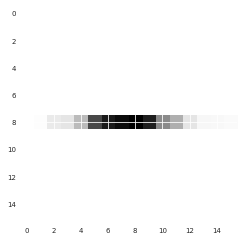

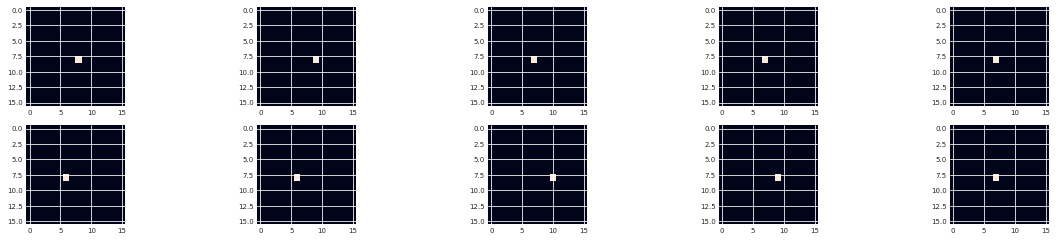

In [4]:
plt.imshow(np.mean(images, axis=0), interpolation='nearest', cmap=cm.Greys)
fig, axes = plt.subplots(2,5, figsize=(20,4))

for i_im, ax in enumerate(axes.flatten()):
    ax.imshow(images[i_im])

In [5]:
cuda = True

In [6]:
x = images[:,None,:,:]
y = np.zeros(len(x), dtype=np.float32)


In [7]:
from reversible.revnet import ReversibleBlock
import torch.nn as nn
def rev_block(n_chans, n_intermediate_chans):
    c = n_chans // 2
    n_i_c = n_intermediate_chans
    return ReversibleBlock(
        nn.Sequential(
            nn.Conv2d(c, n_i_c, (3,3), padding=1),
             nn.ReLU(),
             nn.Conv2d(n_i_c, c, (3,3), padding=1)),
        nn.Sequential(
            nn.Conv2d(c, n_i_c, (3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(n_i_c, c, (3,3), padding=1)))

def plot_sorted_examples(sorted_examples, cmap=cm.Greys_r, vmin=0,vmax=1):
    fig, axes = plt.subplots(2,10, figsize=(20,5))
    for ax, im in zip(axes.flatten(), sorted_examples.squeeze()):
        ax.imshow(im, vmin=vmin, vmax=vmax,cmap=cmap)
    return fig


In [17]:
from reversible.iterator import GenerativeIterator
from reversible.revnet import SubsampleSplitter, ViewAs
from reversible.util import set_random_seeds
from reversible.revnet import init_model_params
import torch as th
set_random_seeds(34093049, True)
feature_model = th.nn.Sequential(
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(4,25),
    rev_block(4,25),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(16,50),
    rev_block(16,50),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(64,100),
    rev_block(64,100),
    ViewAs((-1,64,2,2),(-1,64*2*2)),)
if cuda:
    feature_model = feature_model.cuda()
init_model_params(feature_model, 1)

n_dims = int(np.prod(x.shape[1:]))
n_clusters = int(len(np.unique(y)))
means_per_dim = th.autograd.Variable(th.zeros(n_clusters,n_dims) * 1.0, requires_grad=True)
stds_per_dim = th.autograd.Variable(th.ones(n_clusters,n_dims)  * 0.5, requires_grad=True)

In [18]:
from reversible.sliced import sample_directions
from reversible.util import np_to_var
directions_adv = th.cat([sample_directions(n_dims, True,False),
                         sample_directions(n_dims, True,False),
                         sample_directions(n_dims, True,False),
                        ],dim=0)
directions_adv = th.autograd.Variable(directions_adv.data, requires_grad=True)

inputs = np_to_var(x, dtype=np.float32)
targets = np_to_var((y+1)[:,None], dtype=np.float32)
if cuda == True:
    means_per_dim = th.autograd.Variable(means_per_dim.cuda().data, requires_grad=True)
    stds_per_dim = th.autograd.Variable(stds_per_dim.cuda().data, requires_grad=True)
    directions_adv = directions_adv.cuda()
    inputs = inputs.cuda()
    targets = targets.cuda()

from reversible.training import init_std_mean

init_std_mean(feature_model, inputs, targets, means_per_dim, stds_per_dim,
                 set_phase_interval=True)

optimizer = th.optim.Adam([
    {'params': list(feature_model.parameters()),# + 
                       #[means_per_dim, stds_per_dim],
    'lr': 0.001},],
{'params':[directions_adv,],
    'lr': -0.001},)
iterator = GenerativeIterator(upsample_supervised=True, batch_size=len(inputs))


In [50]:
from reversible.sinkhorn import sinkhorn_to_gauss_dist
from reversible.sliced import sliced_from_samples_for_gauss_dist
from reversible.loss_util import hard_loss_per_cluster

hard_loss_fn = lambda o,m,s : (sinkhorn_to_gauss_dist(o,m,s, epsilon=1e-1, stop_threshold=0.001)
                              + 15 * sliced_from_samples_for_gauss_dist(o,m,s,n_dirs=4, adv_dirs=None))
#hard_loss_fn = lambda o,m,s : sliced_from_samples_for_gauss_dist(o,m,s,n_dirs=2, adv_dirs=directions_adv)
loss_fn = lambda o,d,t,m,s: hard_loss_per_cluster(o,t,m,s, hard_loss_fn)

loss_fn_adv = None # no adversarial training

## let's disable all dimensions except 1

In [51]:
means_per_dim.data = means_per_dim.data * 0
stds_per_dim.data = stds_per_dim.data * 0
stds_per_dim.data[0,131] = 1

In [52]:
def train_one_batch(iterator, feature_model, loss_fn, means_per_dim, stds_per_dim,
                   optimizer):
    b = iterator.get_batches(inputs, targets, None, None)
    b_X, b_y = b.__next__()
    outs = feature_model(b_X)
    loss = loss_fn(outs, None, b_y, means_per_dim, stds_per_dim)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = var_to_np(loss)[0]
    return loss

In [53]:
n_batches_per_dataset = len([b for b in iterator.get_batches(inputs, targets, None, None)])
n_critic_updates = 0
n_updates_per_epoch = int(np.ceil(n_batches_per_dataset / (n_critic_updates + 1.0)))

,total_loss
0,0.615458


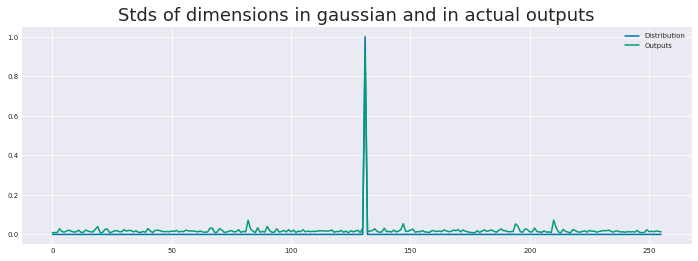

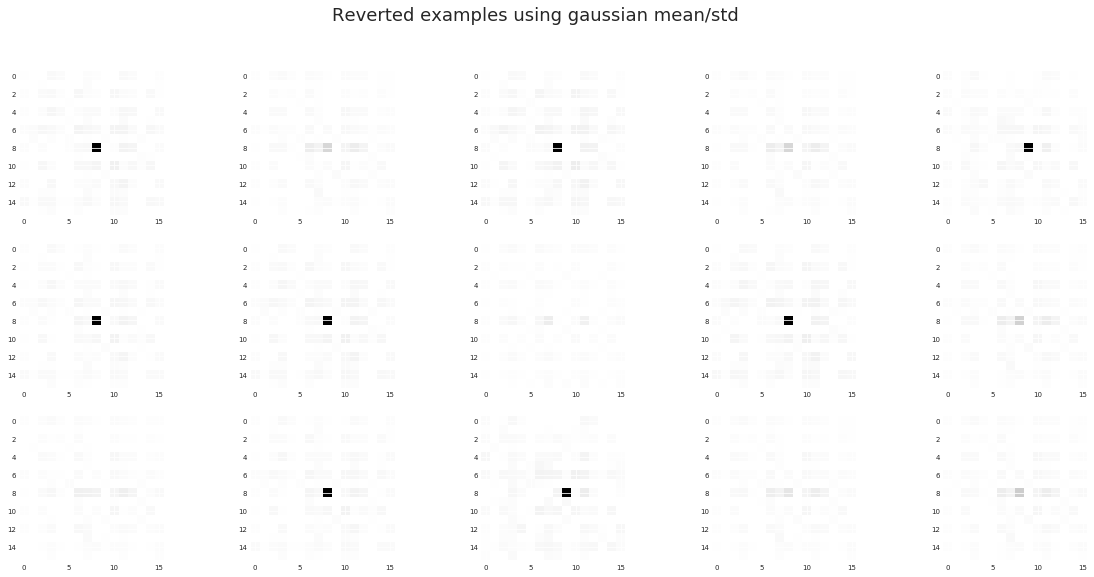

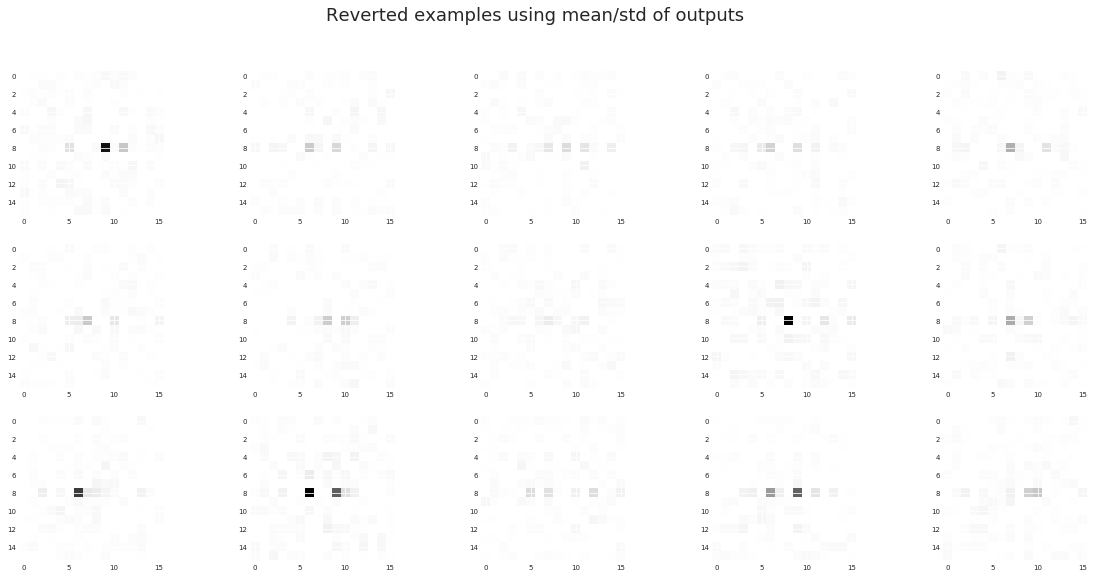

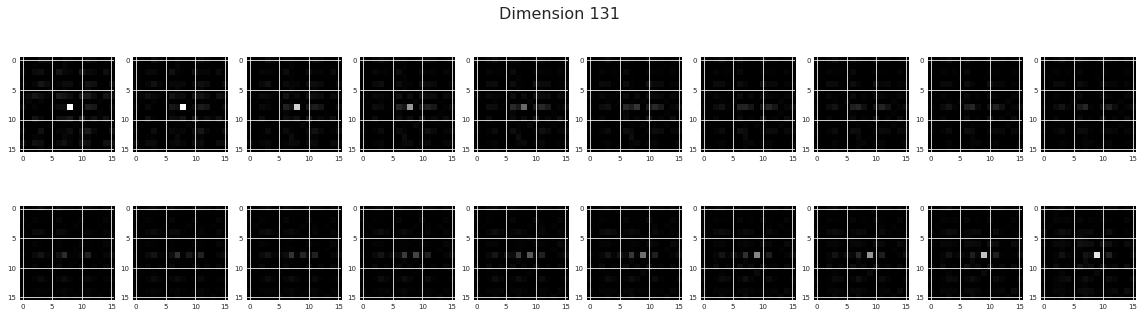

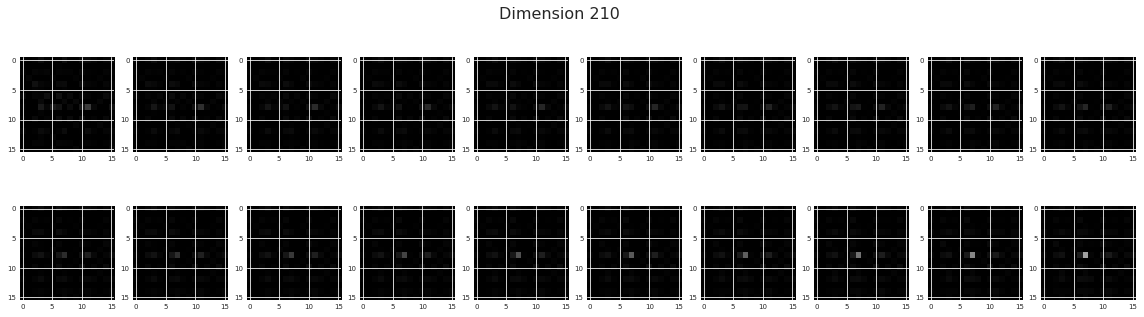

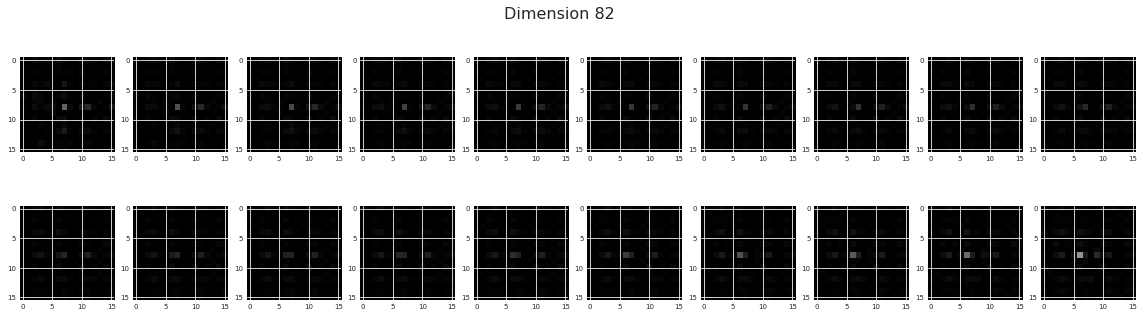

,total_loss
10,0.77915


,total_loss
20,0.710762


,total_loss
30,0.605543


,total_loss
40,0.609851


,total_loss
50,0.568324


,total_loss
60,0.603846


,total_loss
70,0.569011


,total_loss
80,0.567616


,total_loss
90,0.591684


,total_loss
100,0.540473


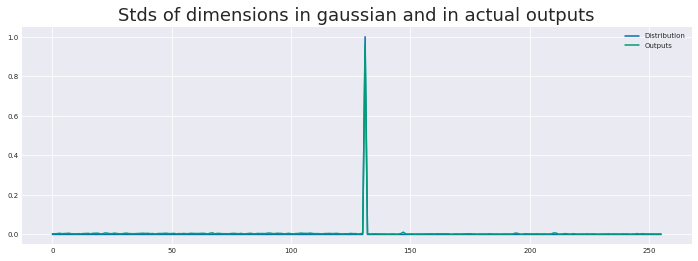

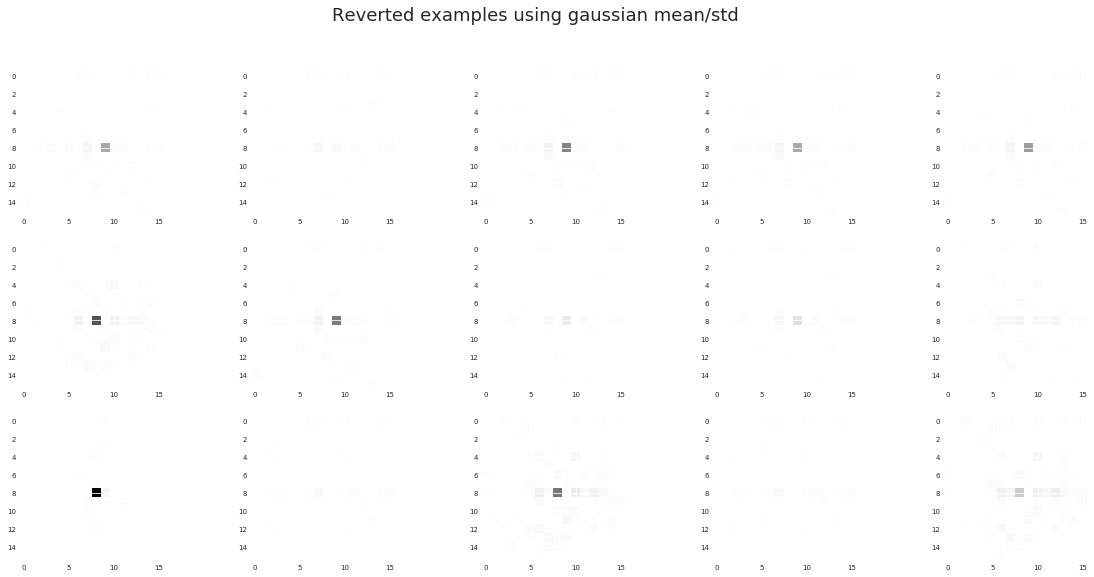

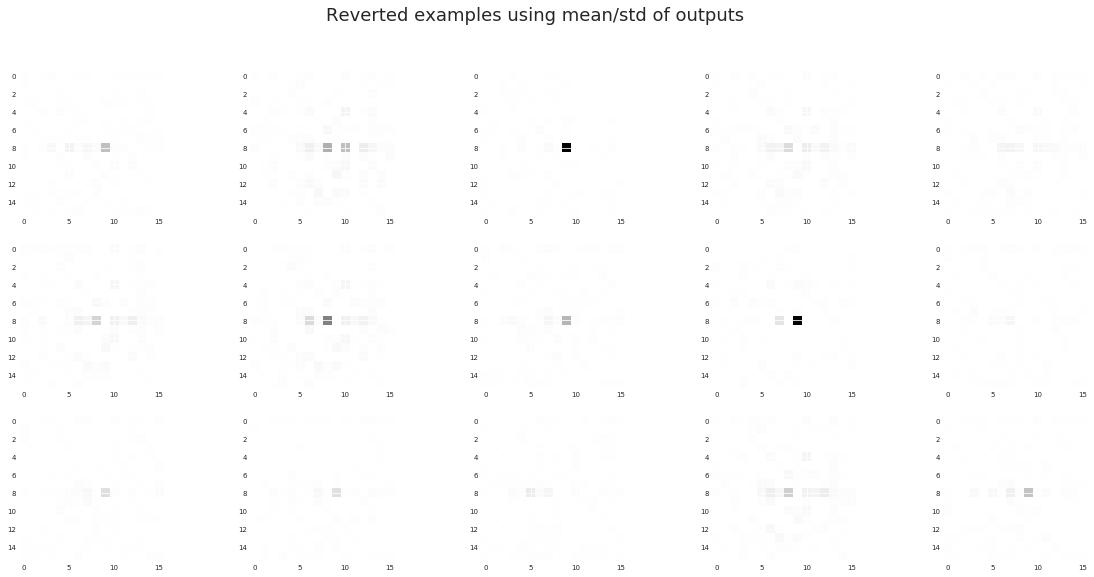

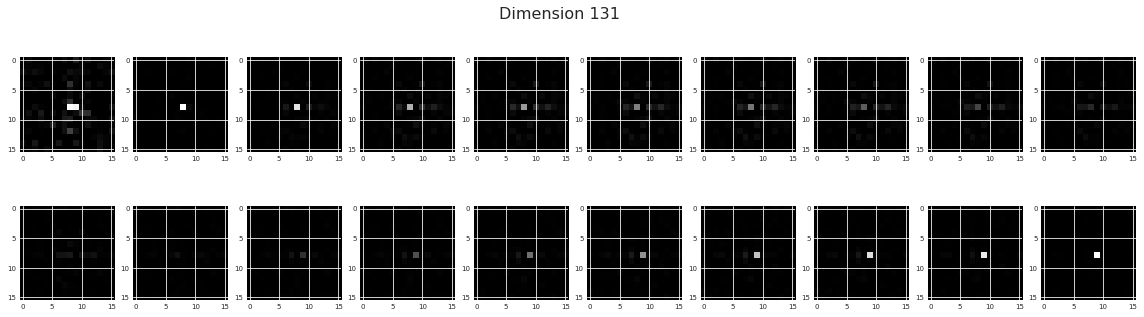

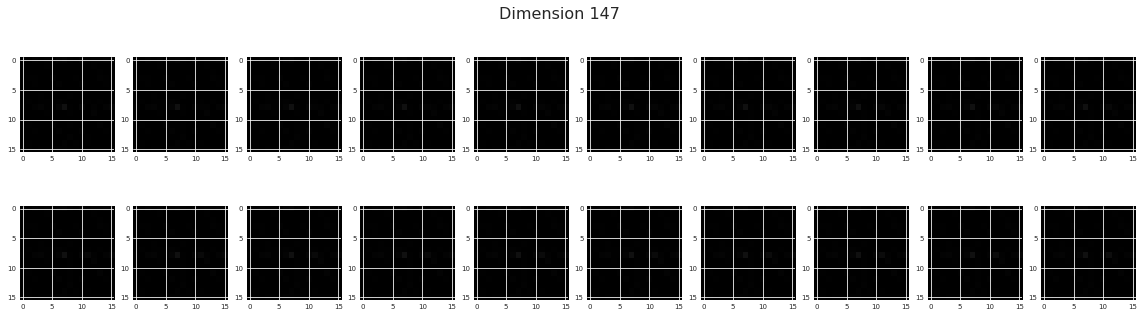

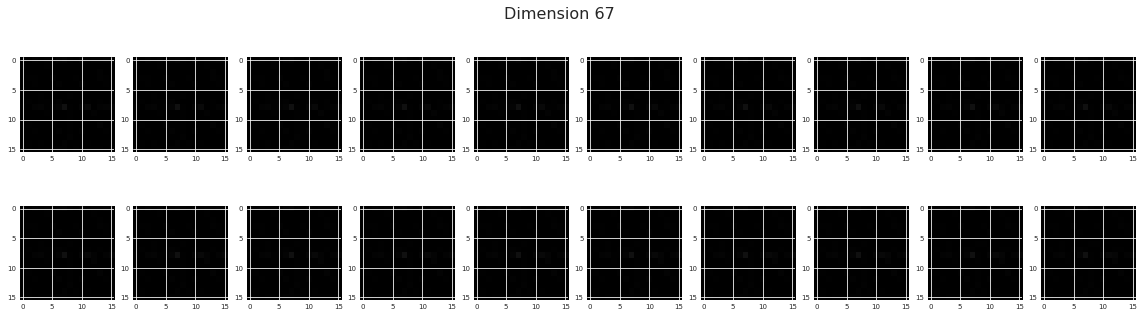

,total_loss
110,0.536326


,total_loss
120,0.580845


,total_loss
130,0.577393


,total_loss
140,0.55819


,total_loss
150,0.597976


,total_loss
160,0.570777


,total_loss
170,0.593078


,total_loss
180,0.619141


,total_loss
190,0.57492


,total_loss
200,0.574336


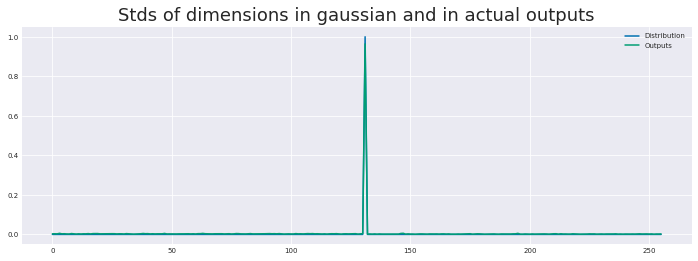

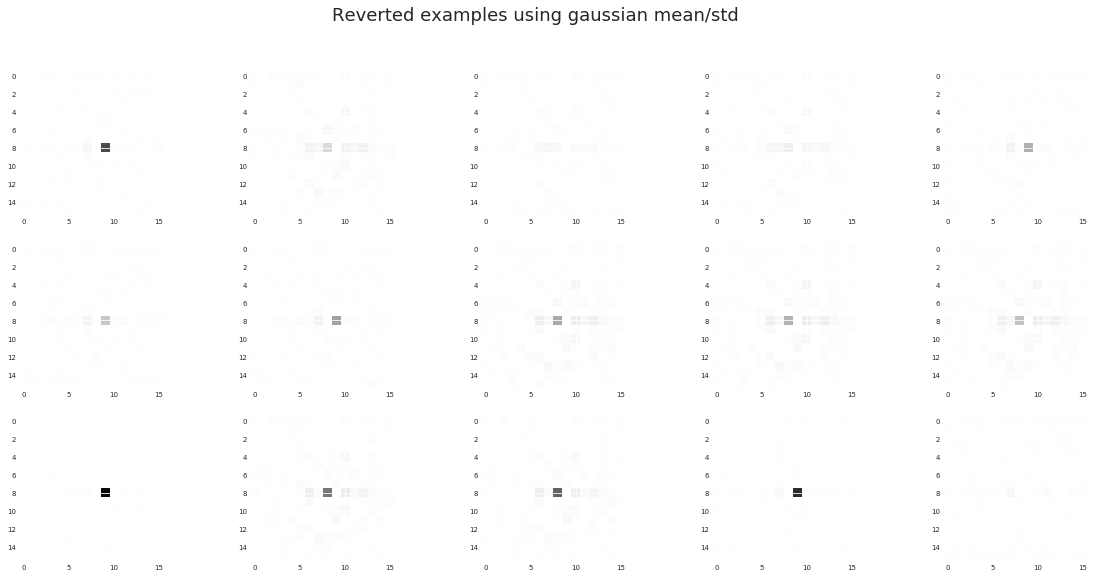

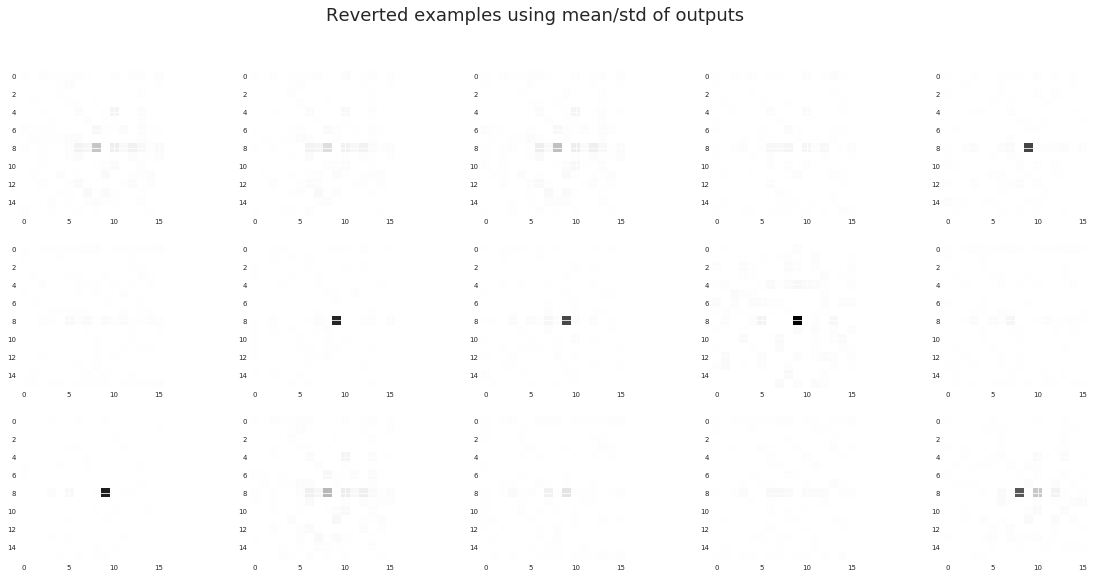

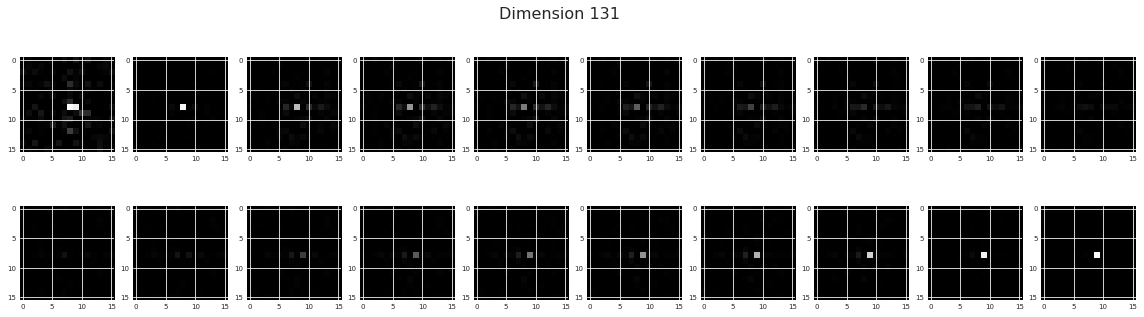

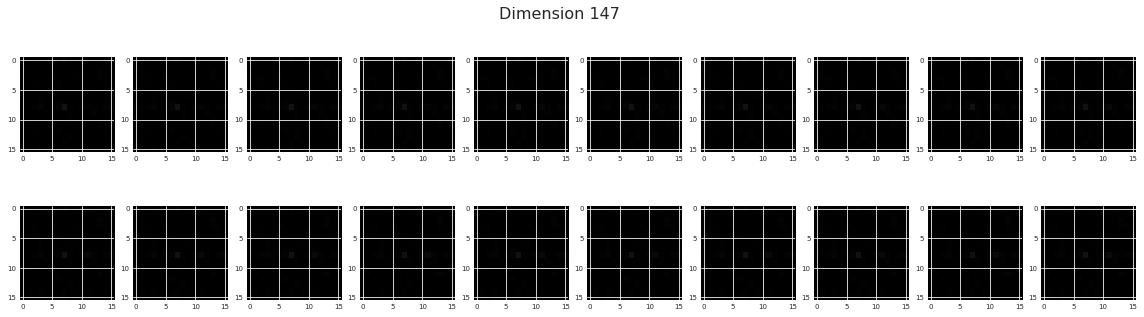

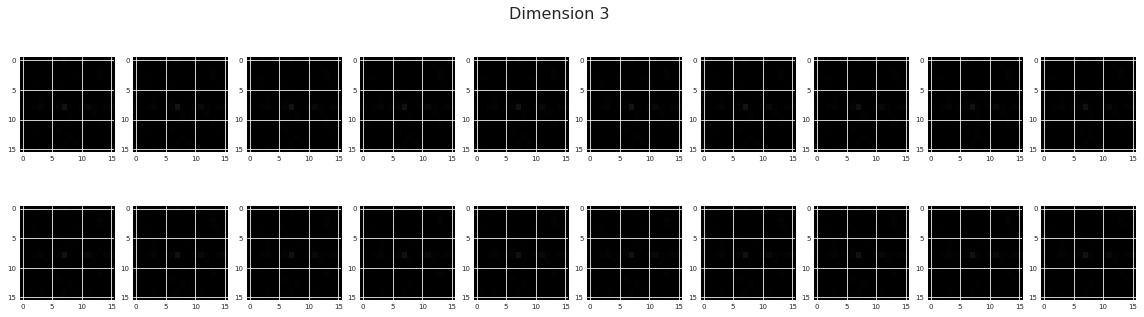

,total_loss
210,0.552386


,total_loss
220,0.637063


,total_loss
230,0.594843


,total_loss
240,0.552658


,total_loss
250,0.587988


,total_loss
260,0.554803


,total_loss
270,0.540164


,total_loss
280,0.577028


,total_loss
290,0.600899


,total_loss
300,0.570032


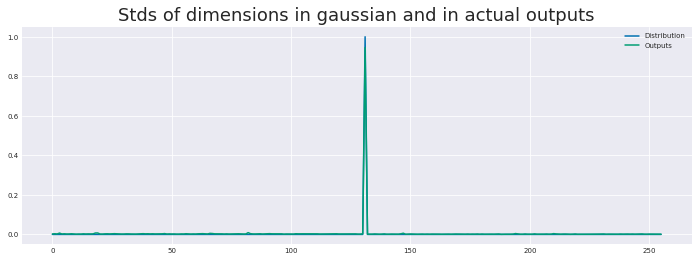

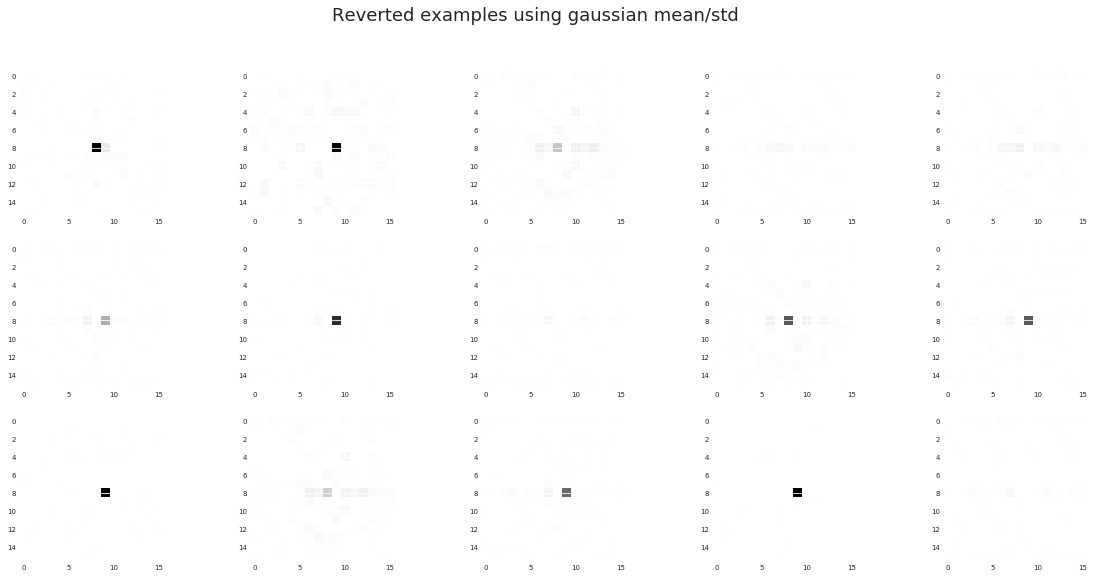

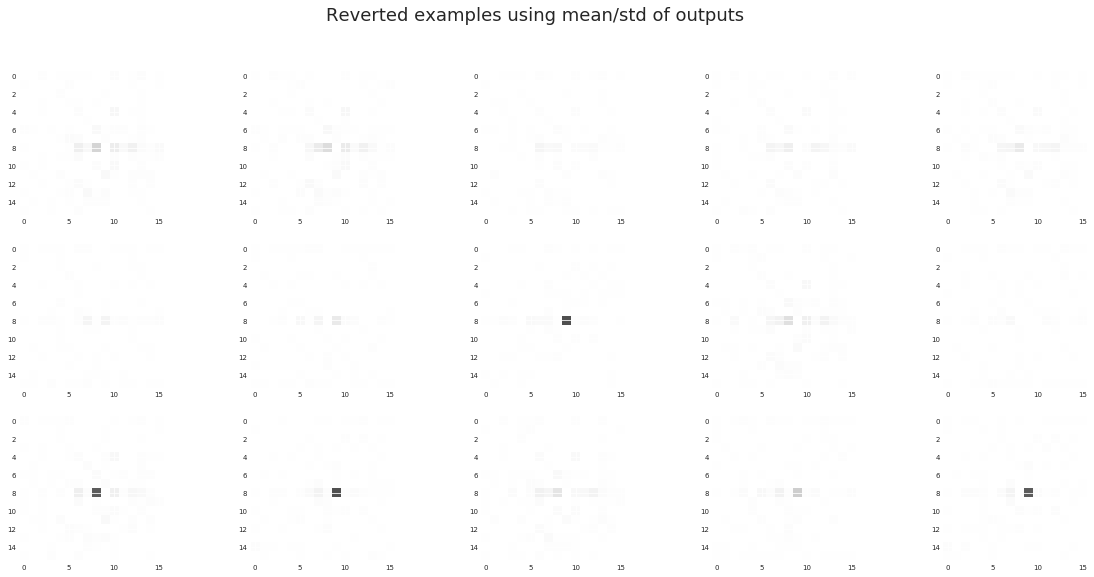

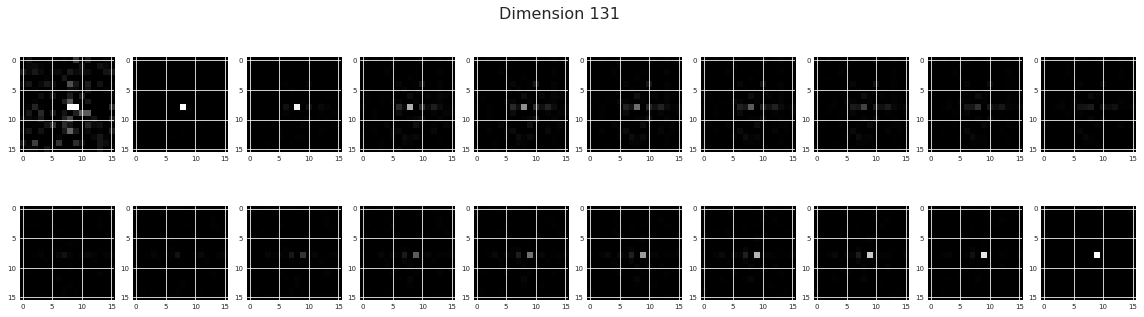

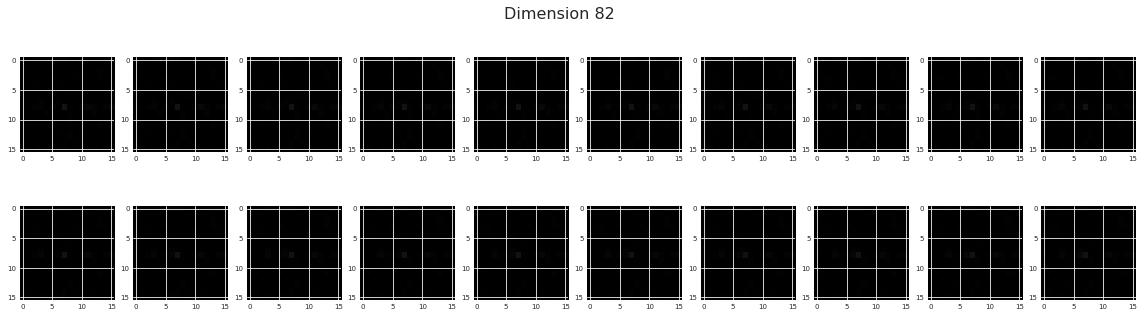

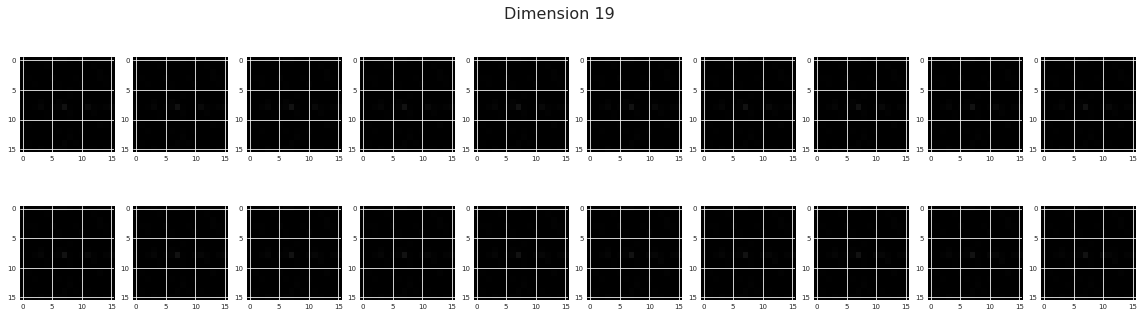

,total_loss
310,0.543859


,total_loss
320,0.582388


,total_loss
330,0.562713


,total_loss
340,0.564976


,total_loss
350,0.582215


,total_loss
360,0.593825


,total_loss
370,0.53905


,total_loss
380,0.548176


,total_loss
390,0.510762


,total_loss
400,0.509348


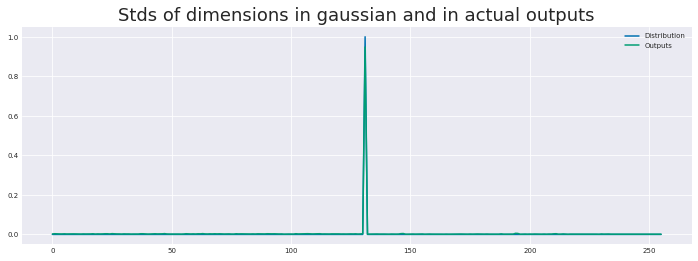

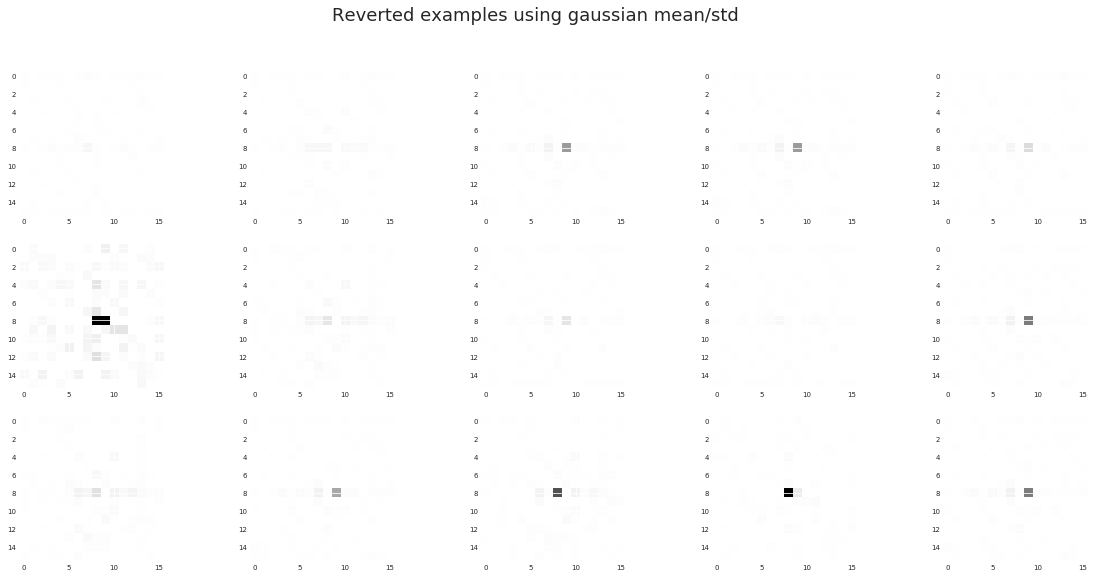

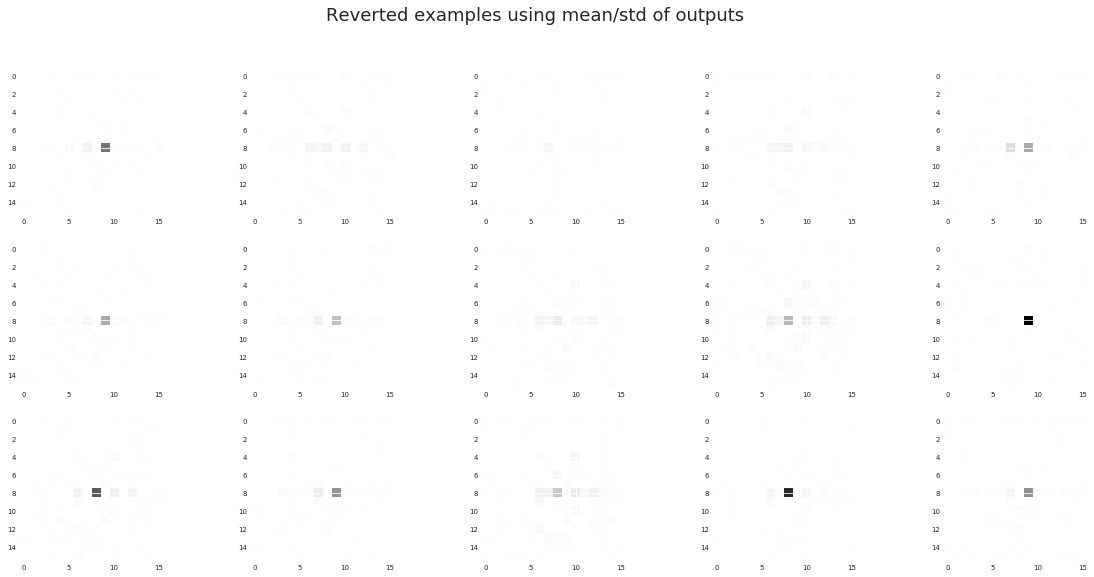

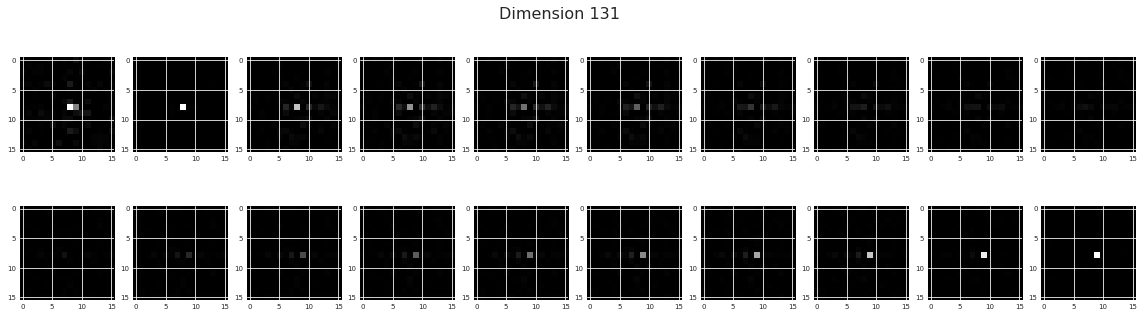

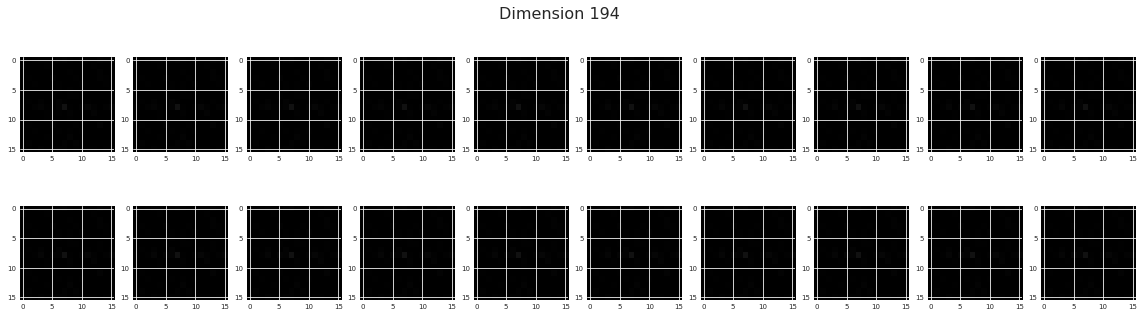

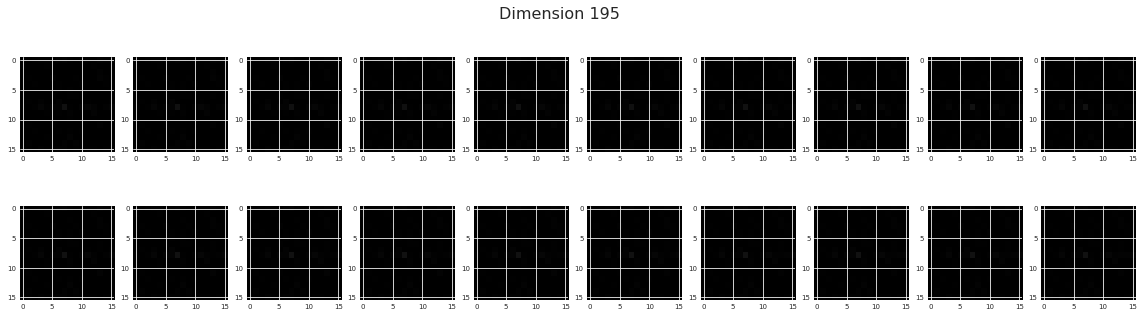

,total_loss
410,0.623949


,total_loss
420,0.605142


,total_loss
430,0.536639


,total_loss
440,0.554896


,total_loss
450,0.580146


,total_loss
460,0.568891


,total_loss
470,0.607085


,total_loss
480,0.544023


,total_loss
490,0.54706


,total_loss
500,0.566332


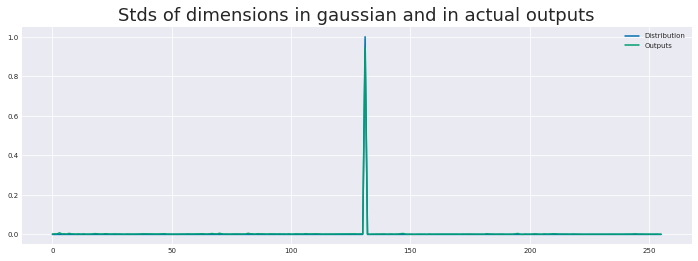

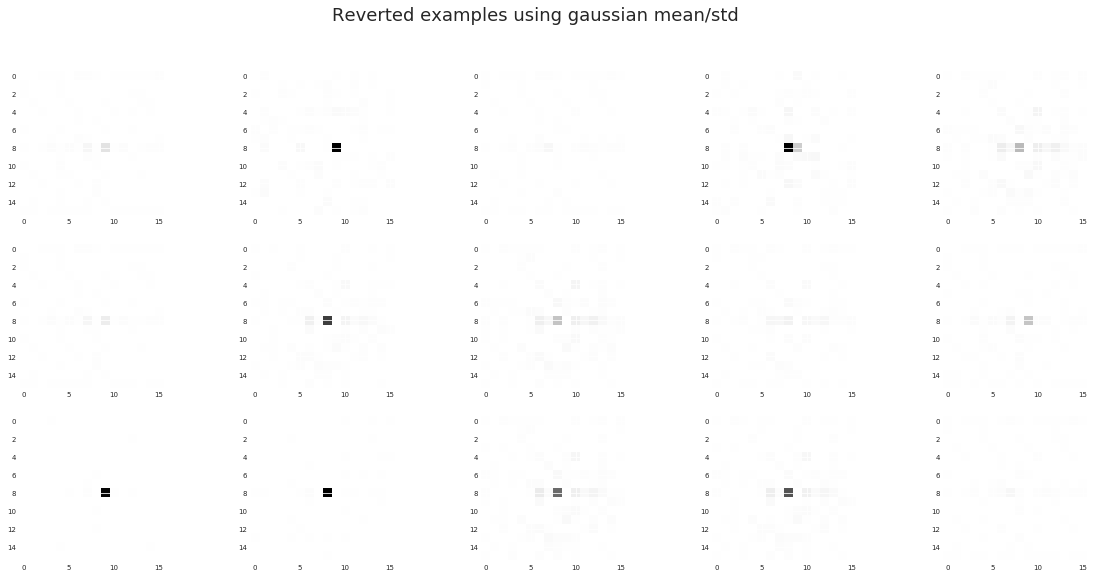

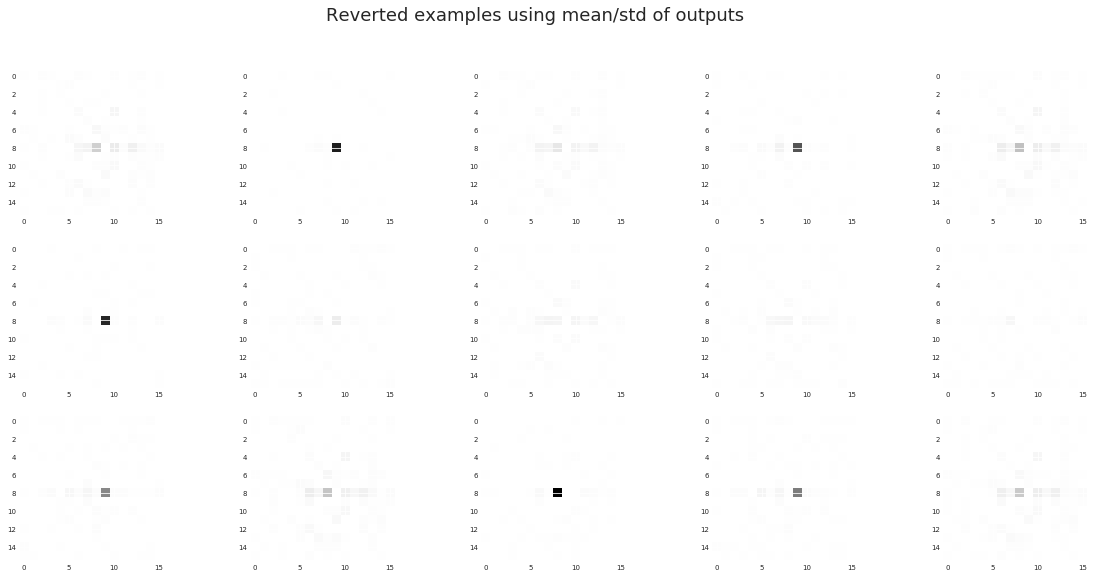

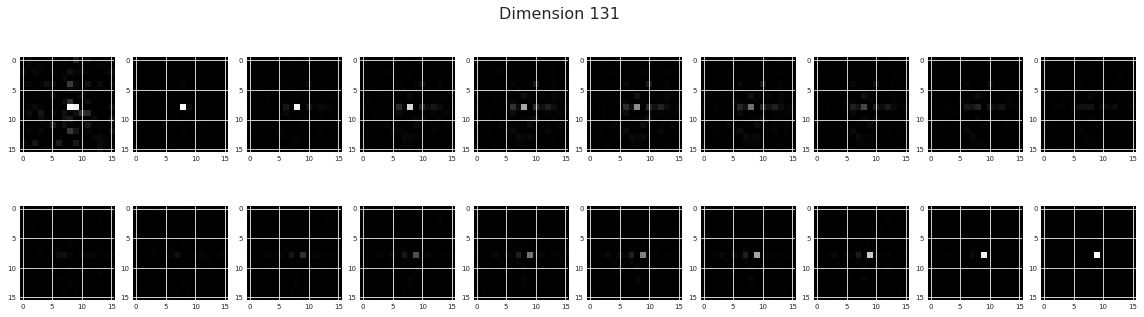

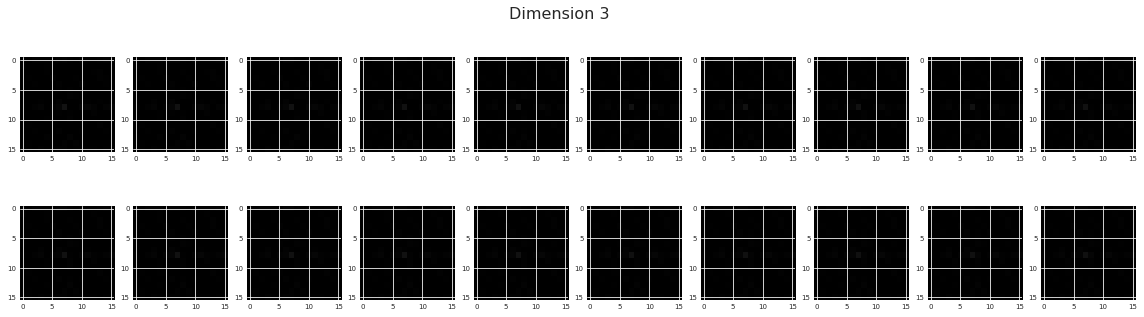

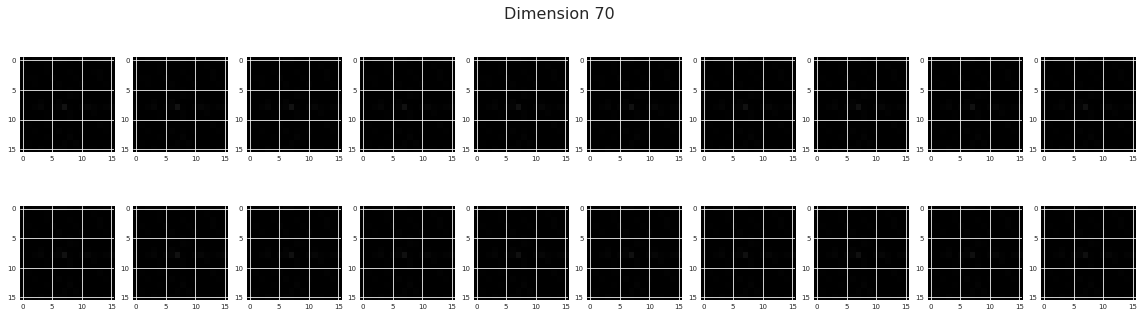

,total_loss
510,0.59742


,total_loss
520,0.536279


,total_loss
530,0.55663


,total_loss
540,0.560291


,total_loss
550,0.552137


,total_loss
560,0.605291


,total_loss
570,0.541438


,total_loss
580,0.563105


,total_loss
590,0.578162


,total_loss
600,0.543641


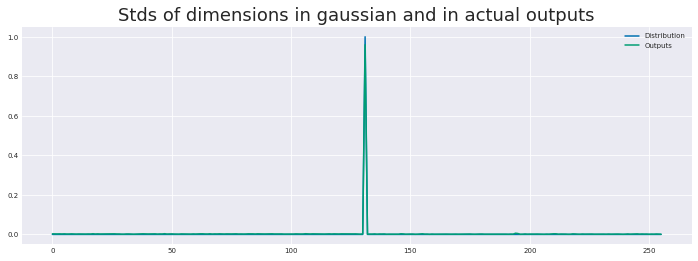

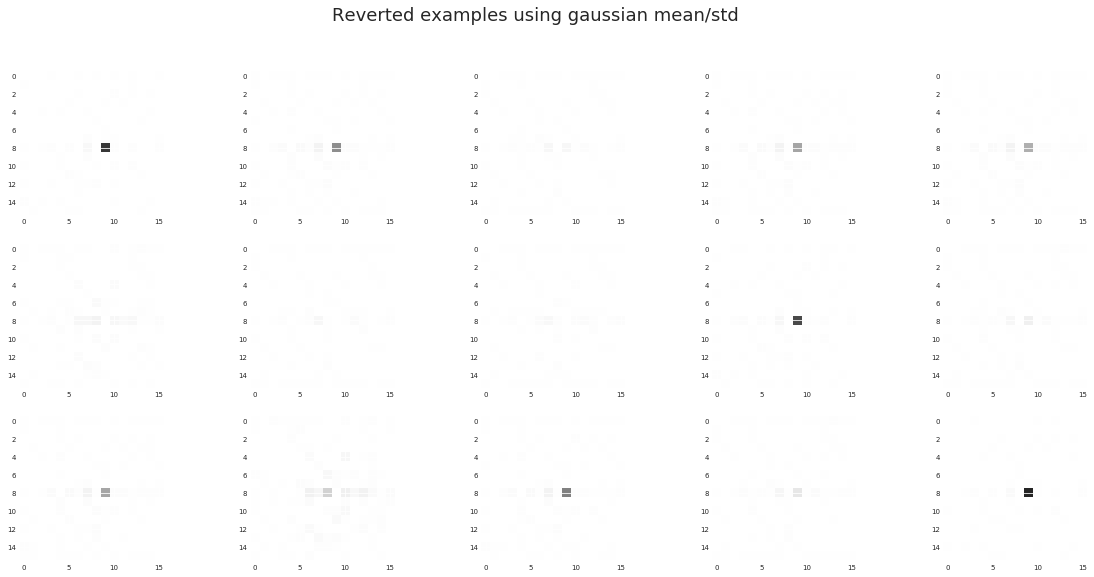

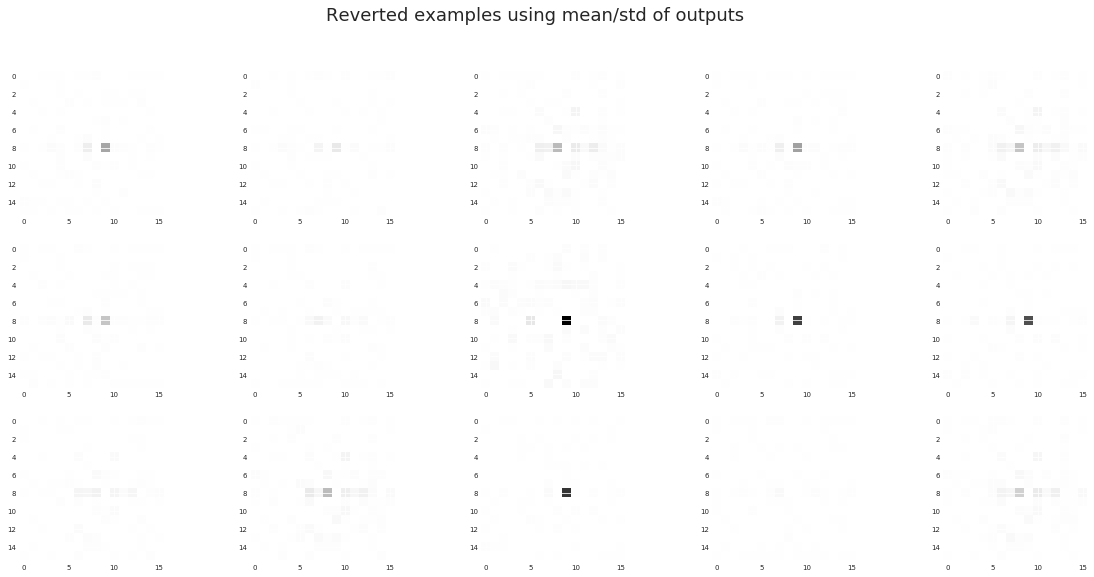

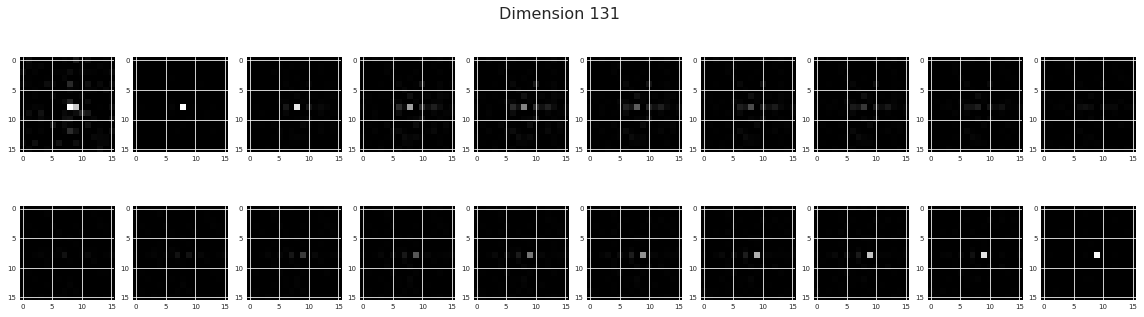

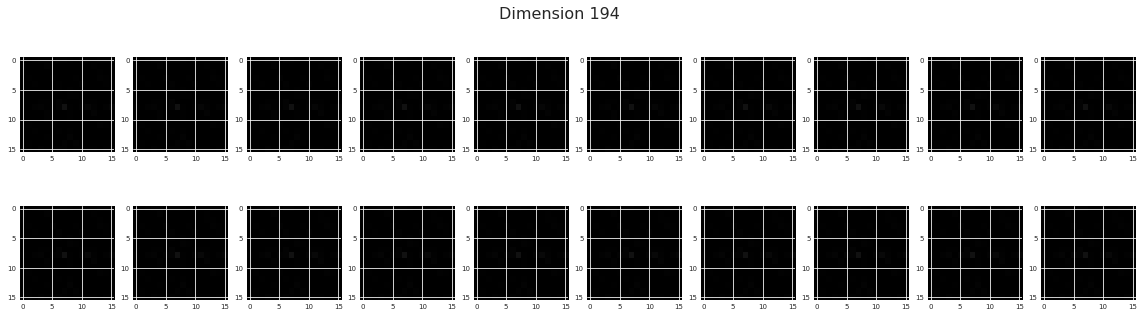

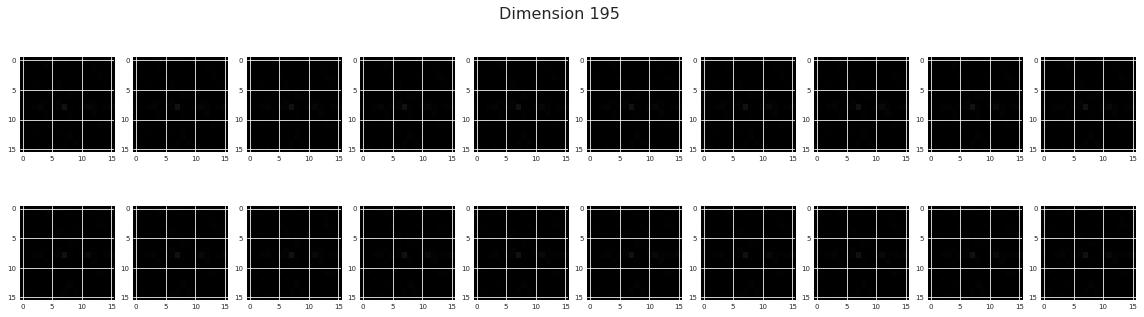

,total_loss
610,0.543106


,total_loss
620,0.557944


,total_loss
630,0.55498


,total_loss
640,0.579298


,total_loss
650,0.528121


,total_loss
660,0.52915


,total_loss
670,0.530636


,total_loss
680,0.53907


,total_loss
690,0.552501


,total_loss
700,0.594635


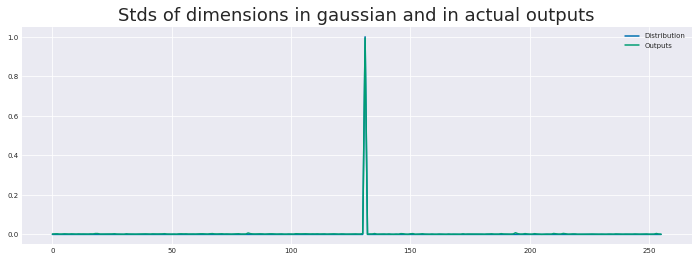

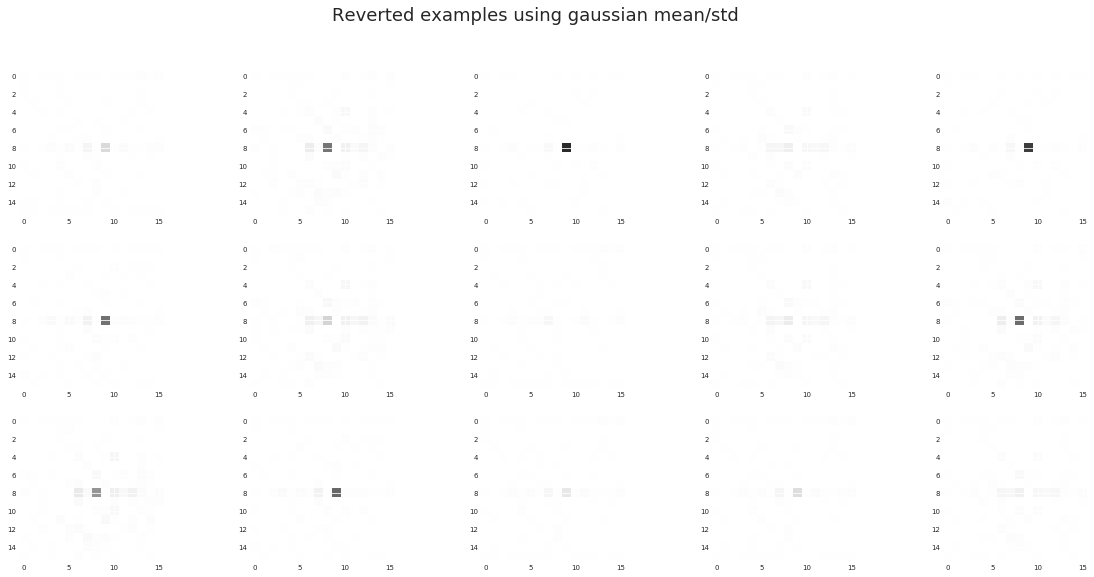

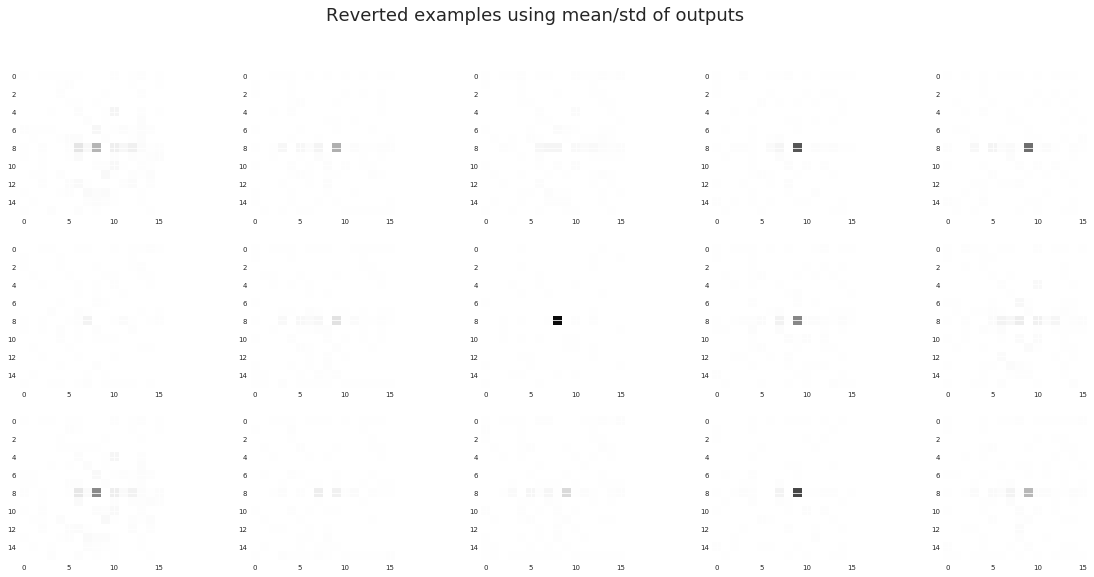

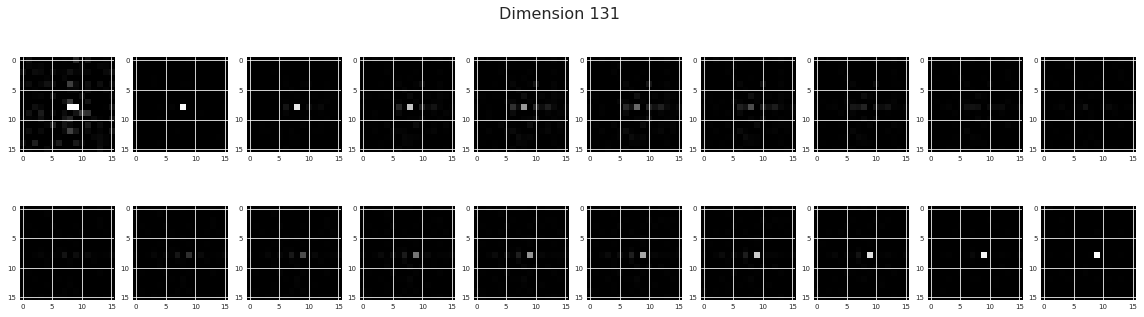

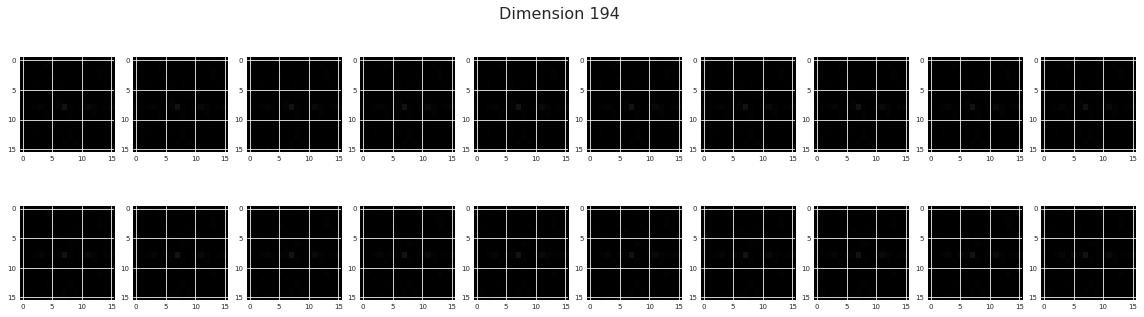

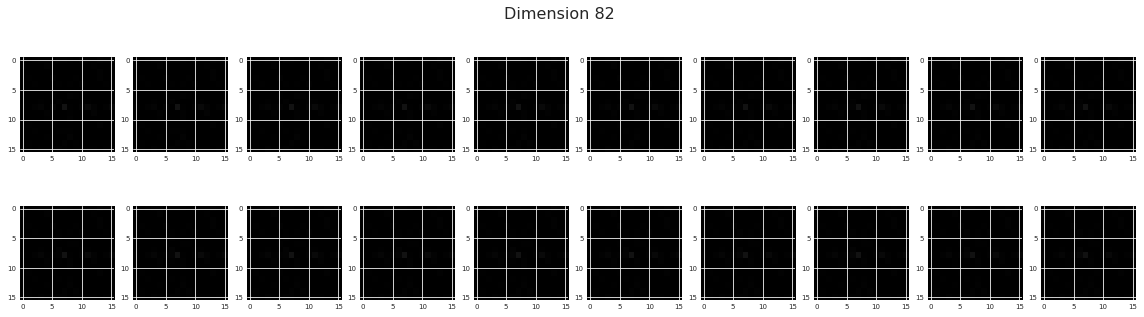

,total_loss
710,0.539341


,total_loss
720,0.563043


,total_loss
730,0.54682


,total_loss
740,0.576166


,total_loss
750,0.582488


,total_loss
760,0.54969


,total_loss
770,0.53705


,total_loss
780,0.527172


,total_loss
790,0.526002


,total_loss
800,0.537628


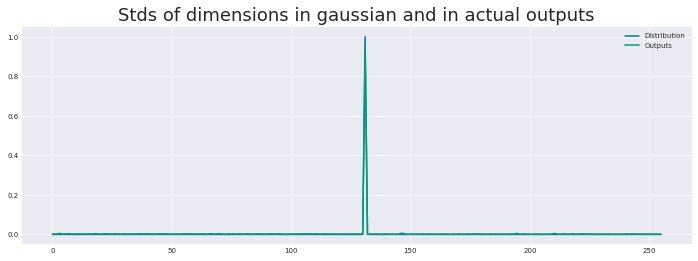

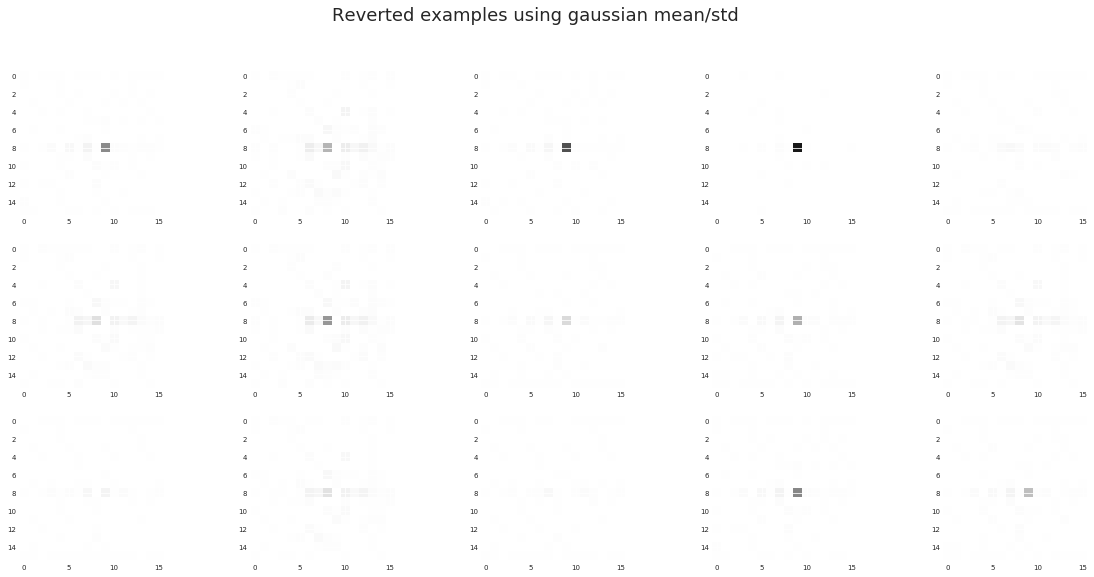

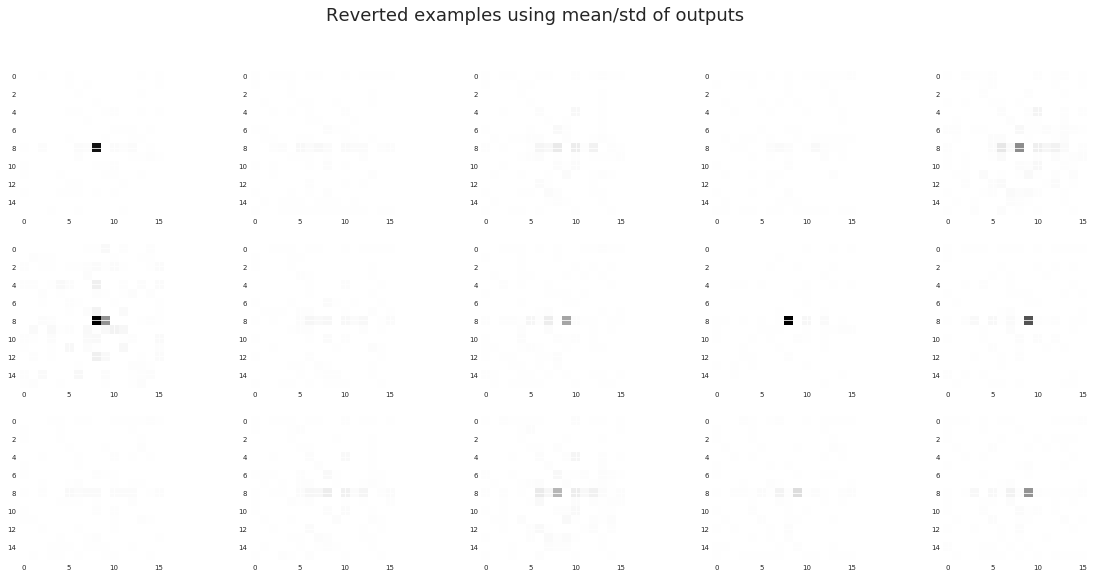

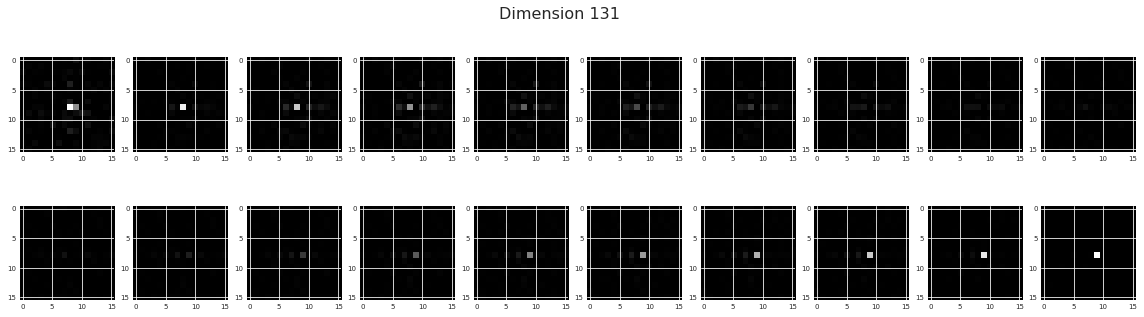

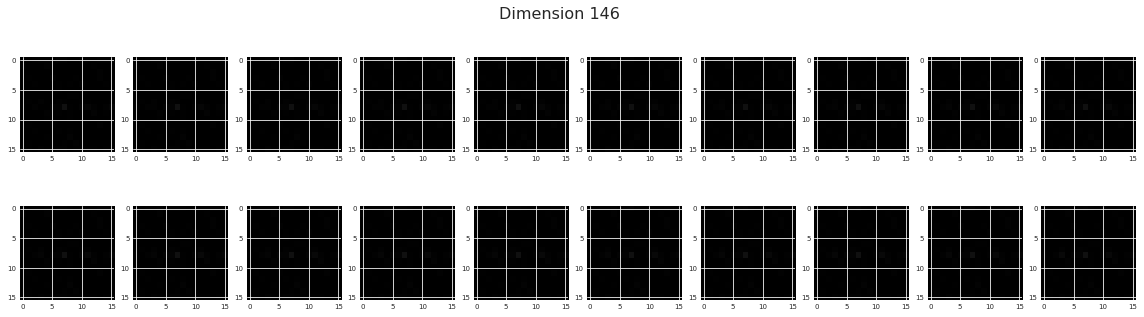

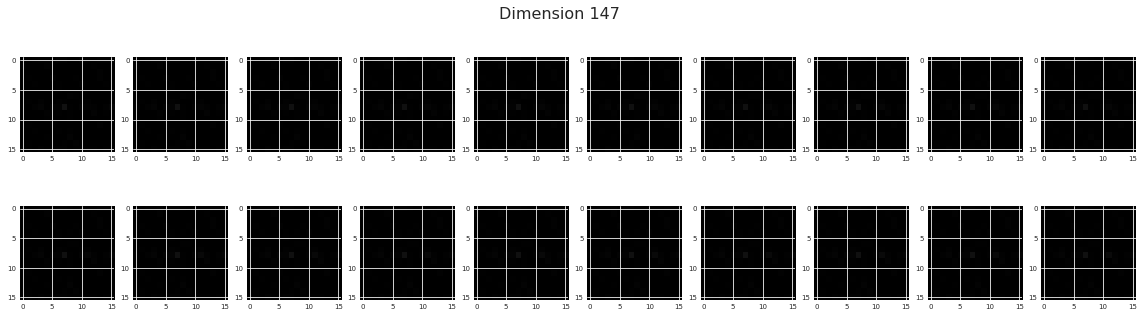

,total_loss
810,0.550509


,total_loss
820,0.596117


,total_loss
830,0.579832


,total_loss
840,0.569023


,total_loss
850,0.566973


,total_loss
860,0.524773


,total_loss
870,0.540768


,total_loss
880,0.542799


,total_loss
890,0.542649


,total_loss
900,0.533715


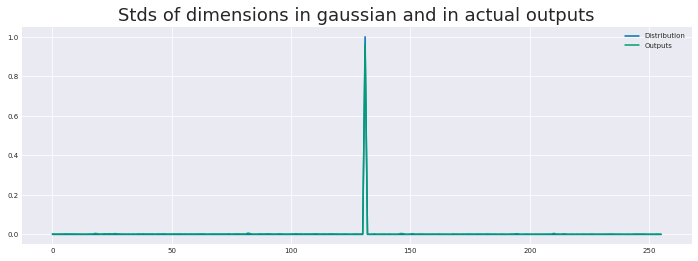

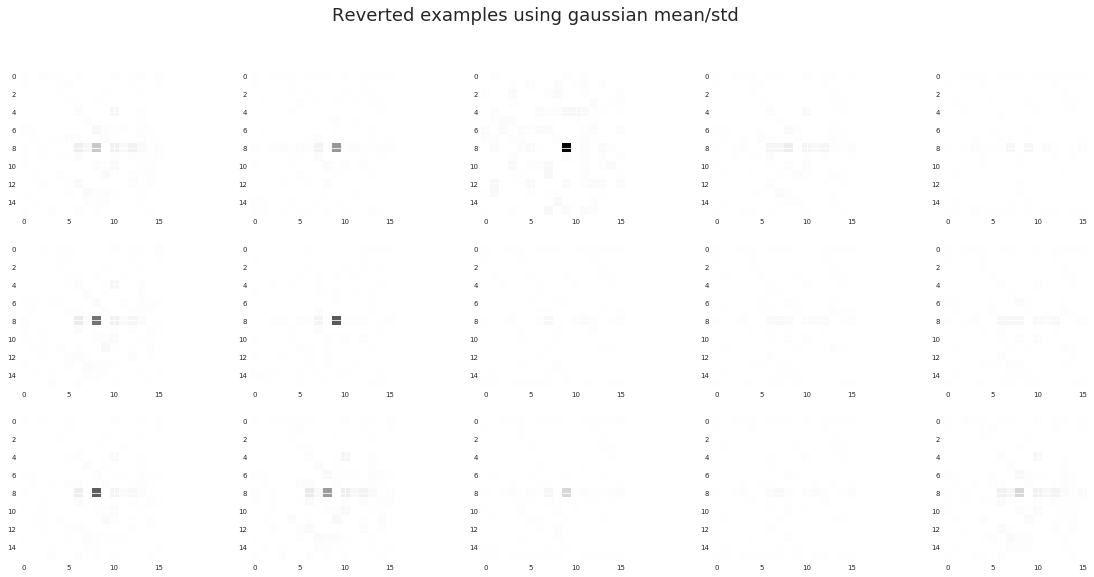

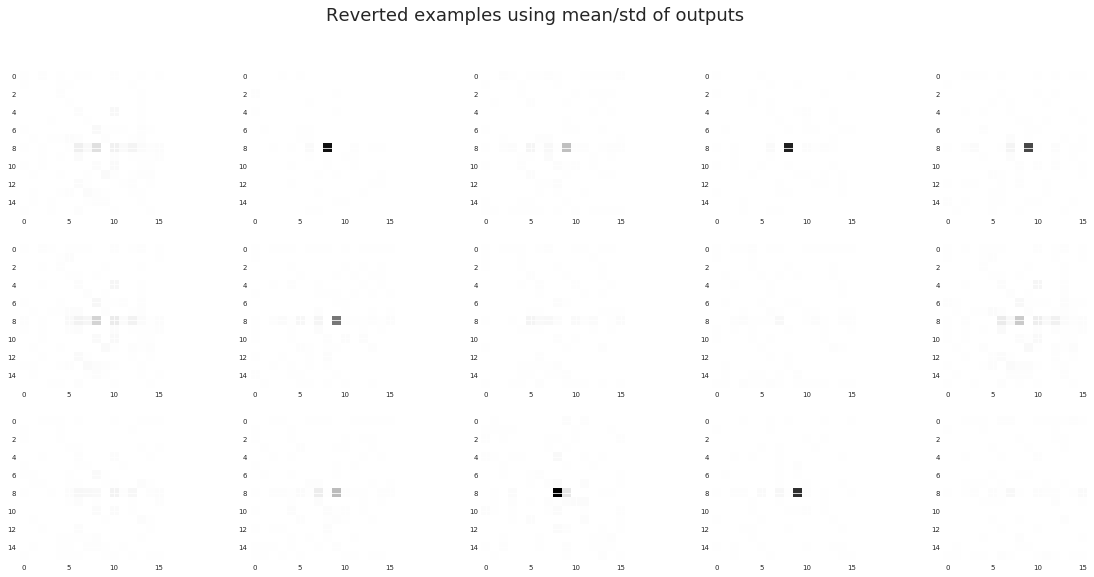

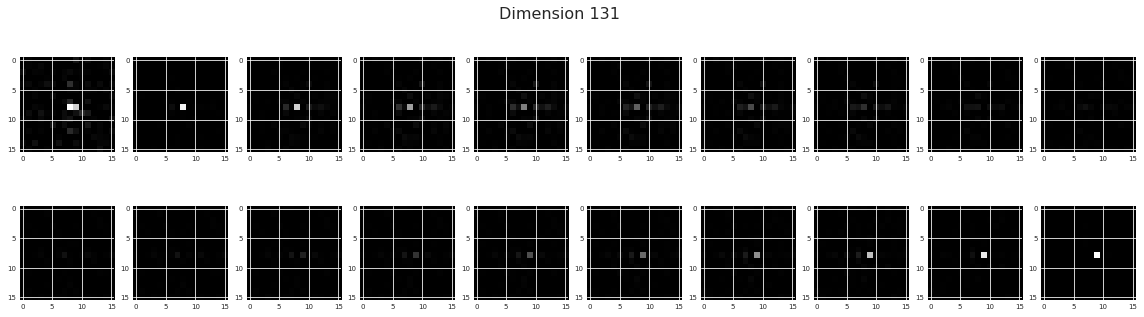

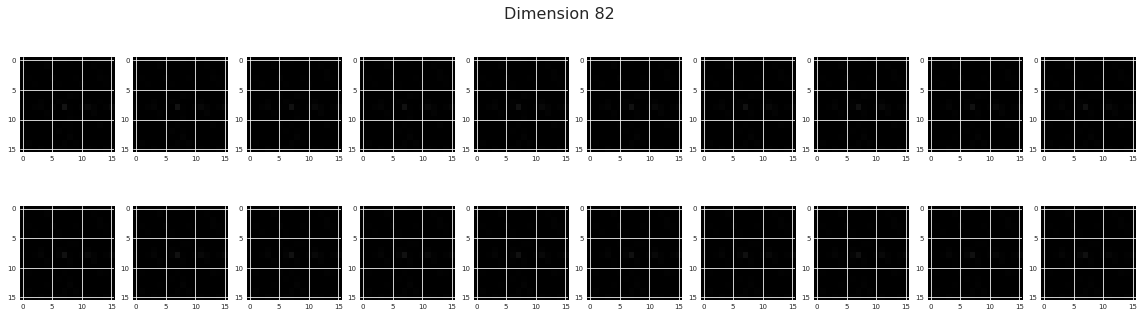

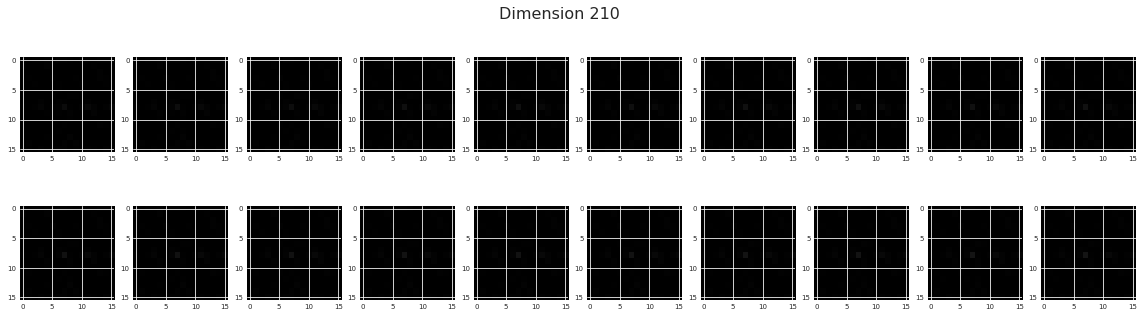

,total_loss
910,0.51365


,total_loss
920,0.538809


,total_loss
930,0.563245


,total_loss
940,0.585984


,total_loss
950,0.523374


,total_loss
960,0.530263


,total_loss
970,0.56167


,total_loss
980,0.57214


,total_loss
990,0.559671


,total_loss
1000,0.604836


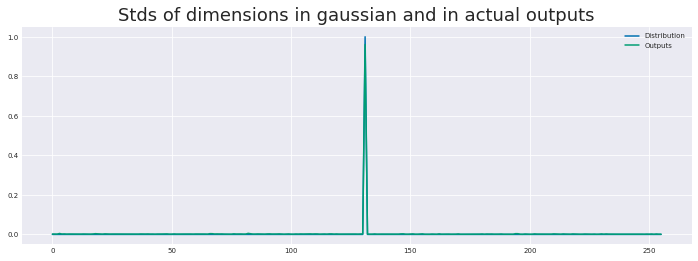

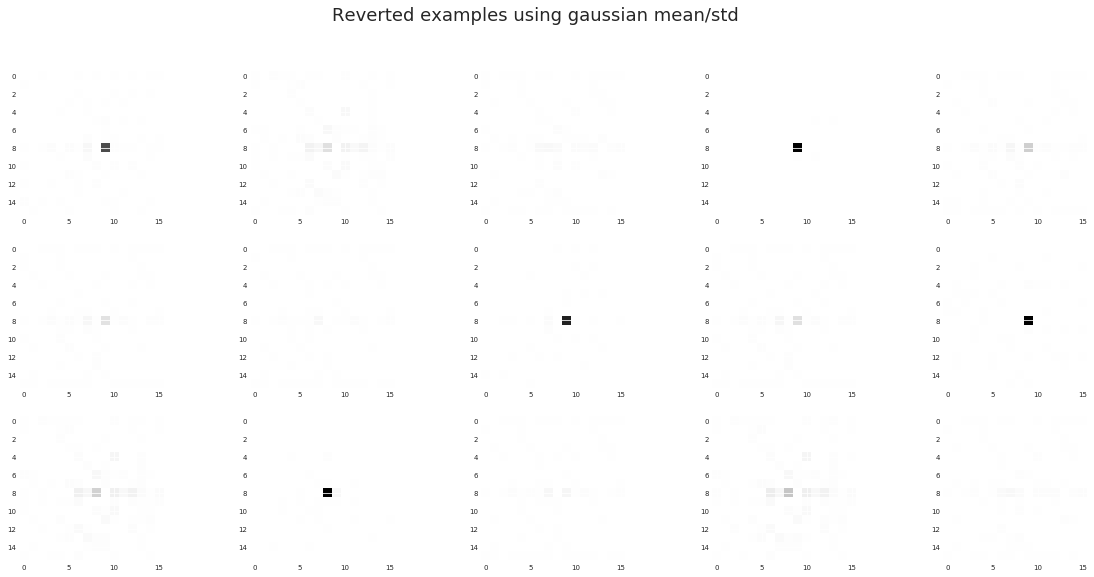

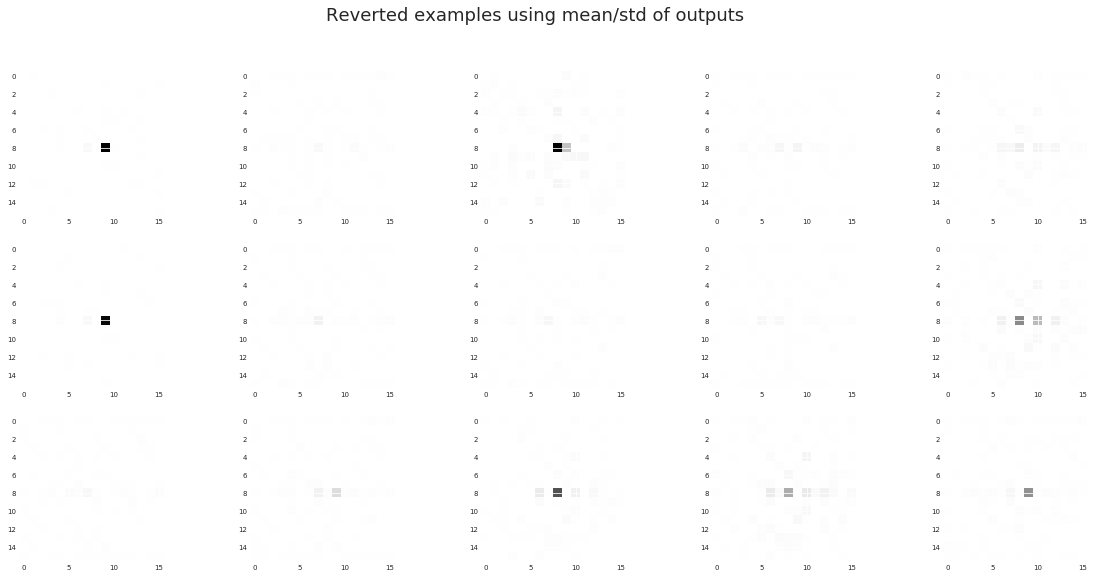

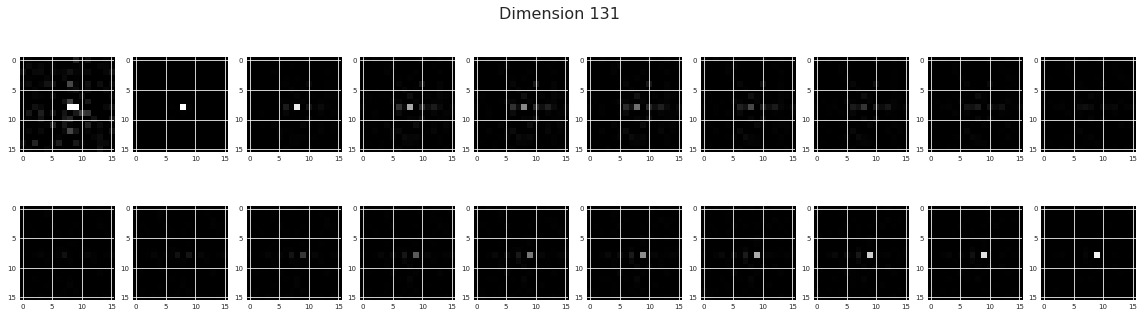

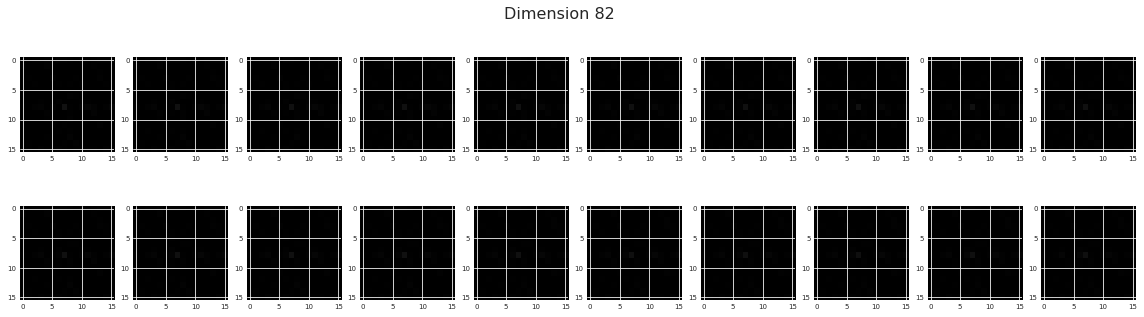

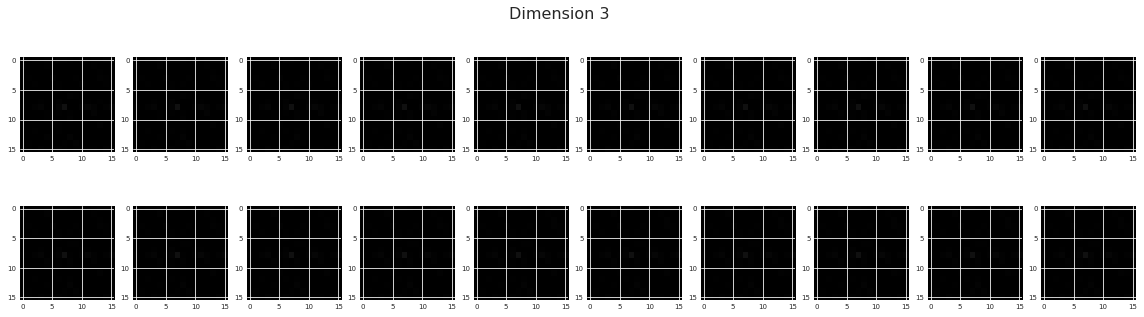

,total_loss
1010,0.515997


,total_loss
1020,0.506028


,total_loss
1030,0.509586


,total_loss
1040,0.567174


,total_loss
1050,0.568915


,total_loss
1060,0.59039


,total_loss
1070,0.567006


,total_loss
1080,0.597946


,total_loss
1090,0.560148


,total_loss
1100,0.600764


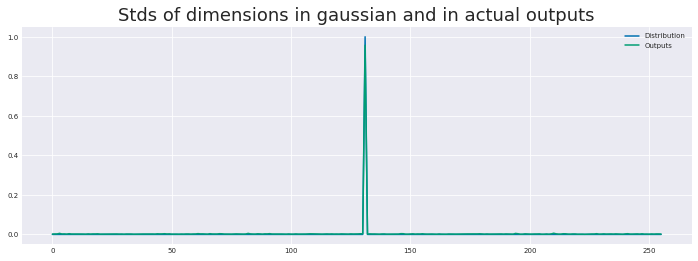

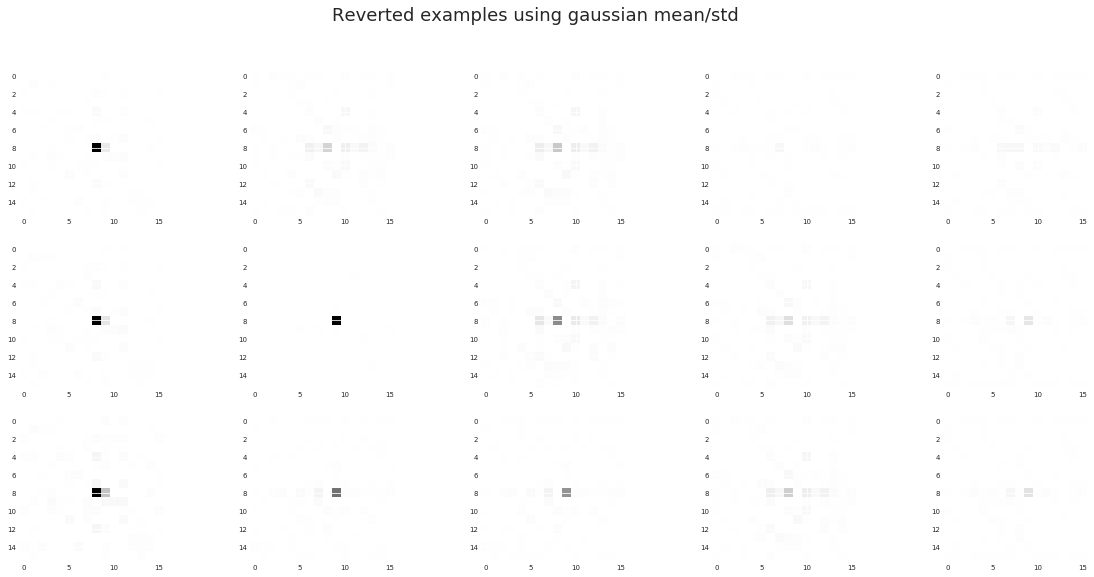

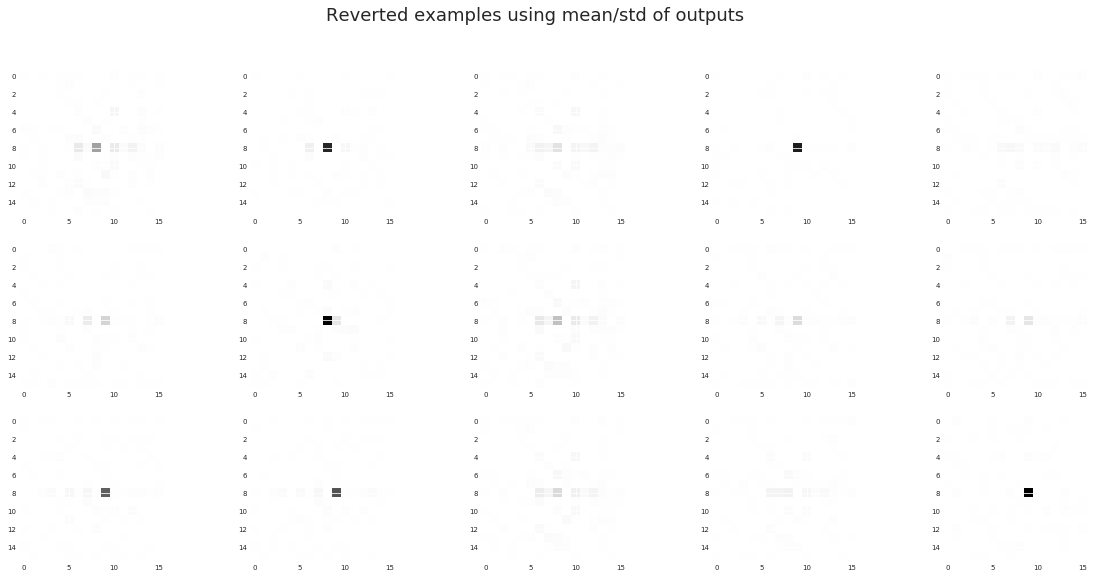

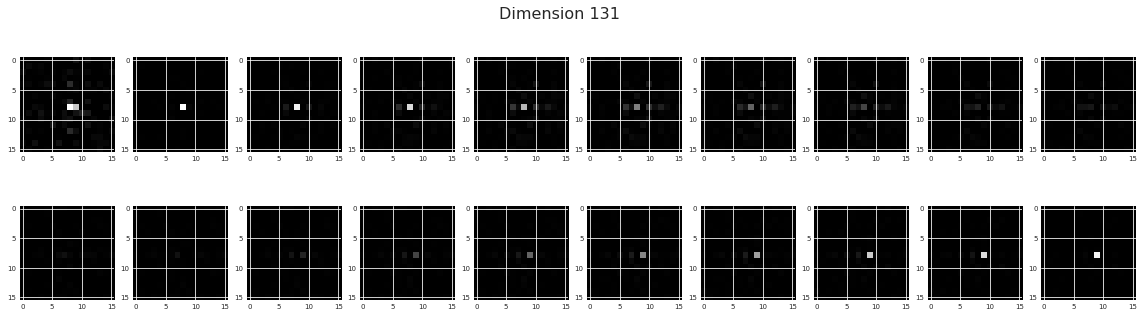

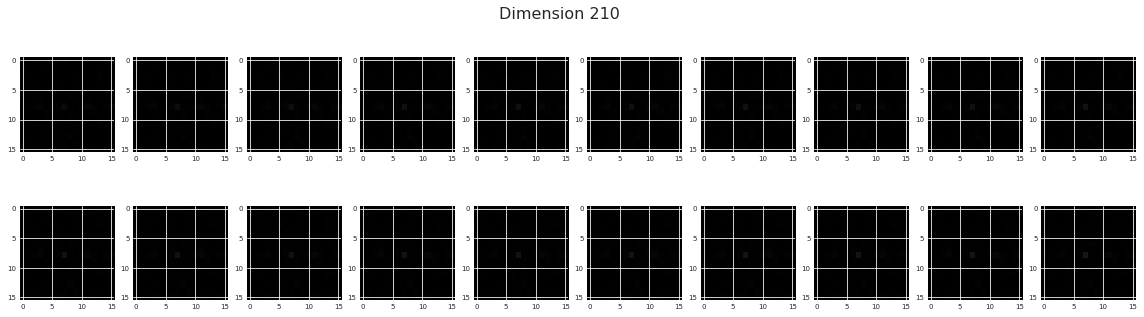

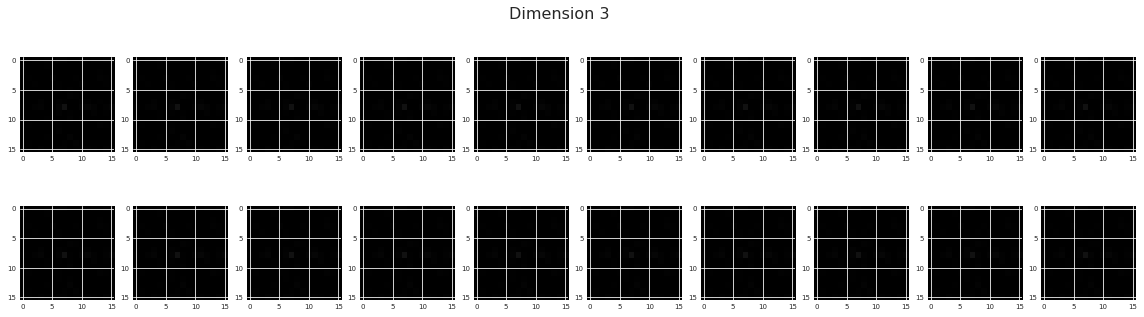

,total_loss
1110,0.542477


,total_loss
1120,0.539042


,total_loss
1130,0.577912


,total_loss
1140,0.540799


,total_loss
1150,0.531304


,total_loss
1160,0.609562


,total_loss
1170,0.586416


,total_loss
1180,0.586464


,total_loss
1190,0.529218


,total_loss
1200,0.527487


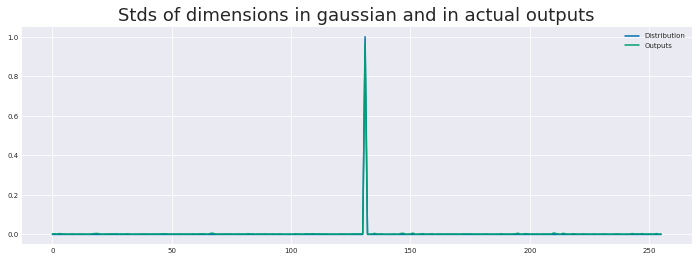

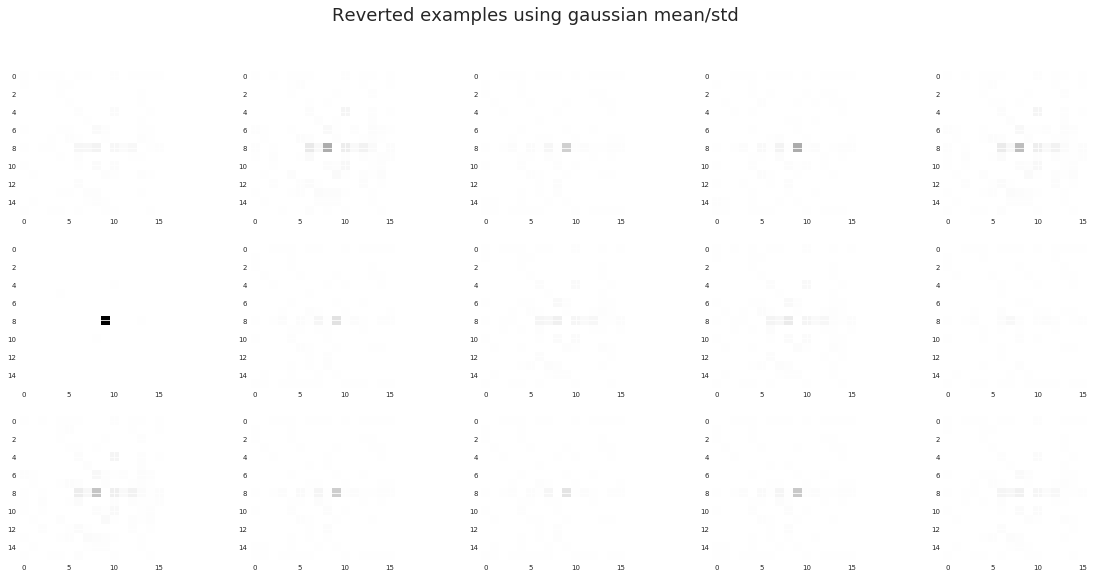

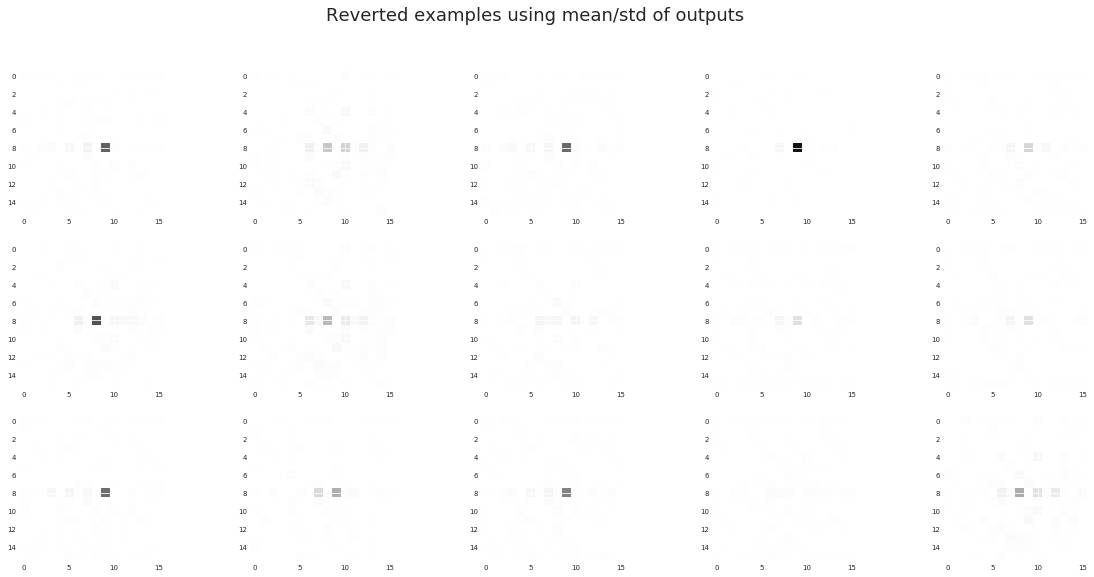

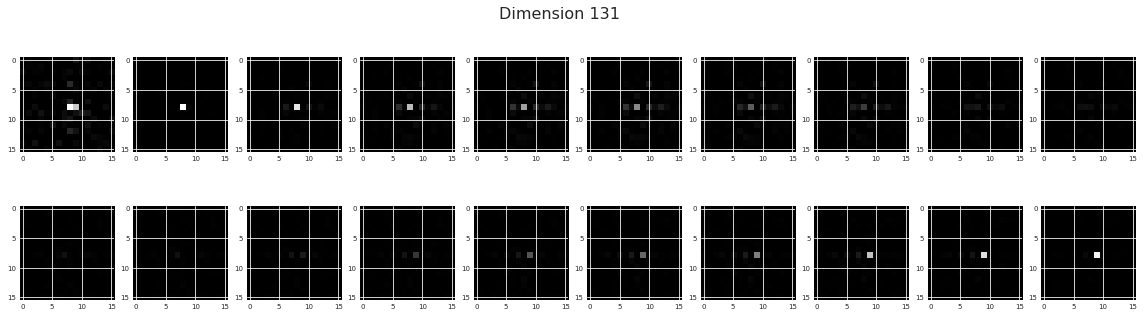

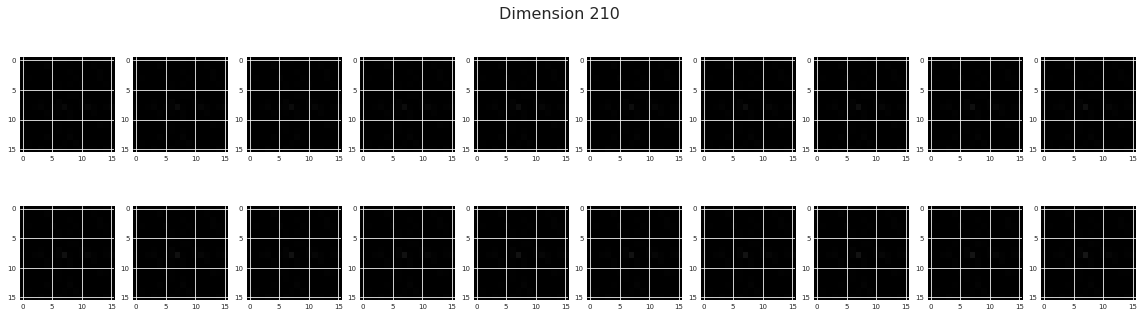

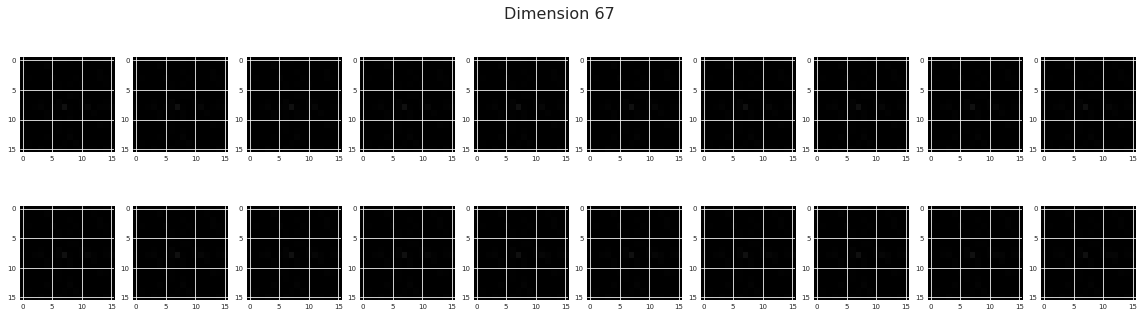

,total_loss
1210,0.555171


,total_loss
1220,0.571586


,total_loss
1230,0.533765


,total_loss
1240,0.608933


,total_loss
1250,0.561817


,total_loss
1260,0.529669


,total_loss
1270,0.522618


,total_loss
1280,0.573509


,total_loss
1290,0.535965


,total_loss
1300,0.543486


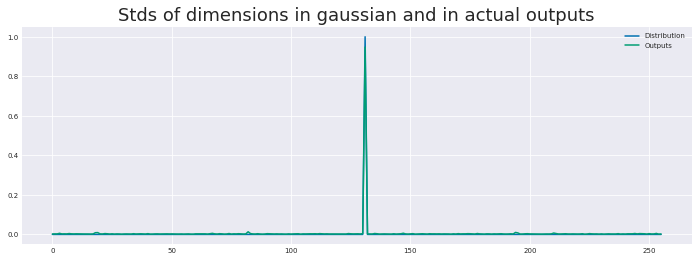

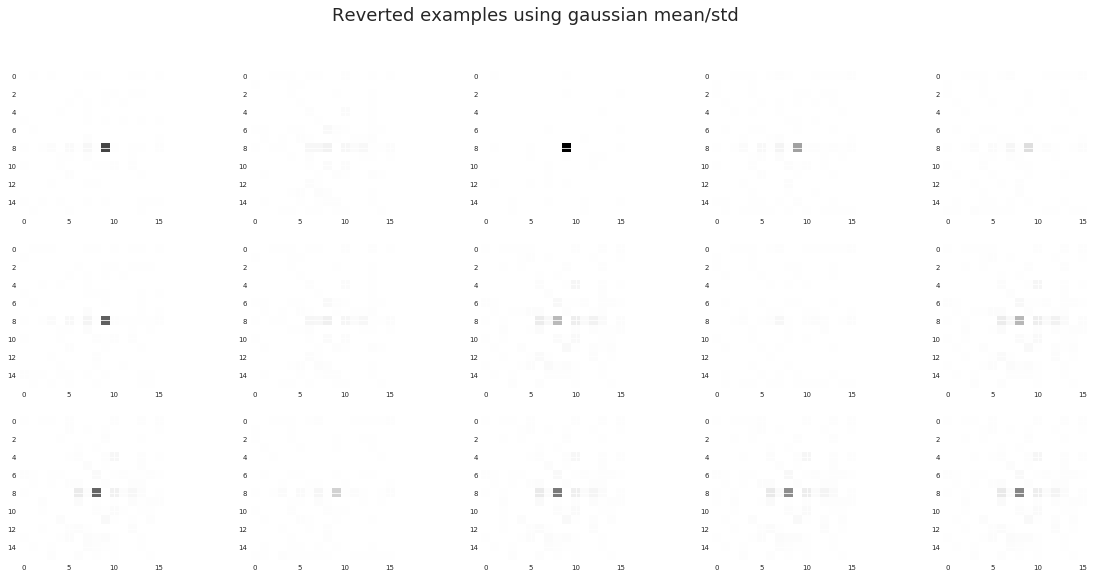

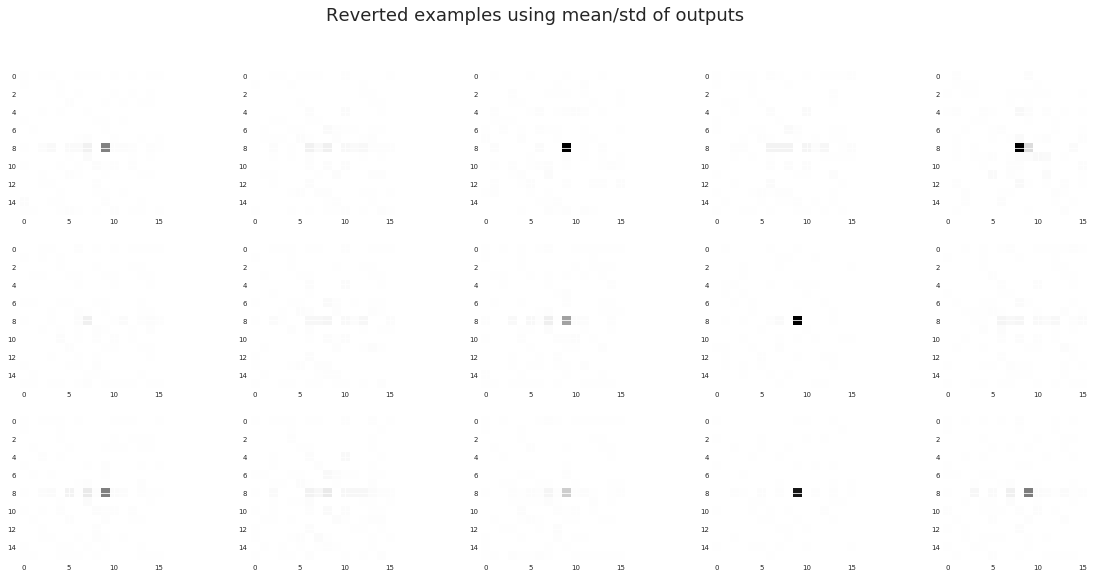

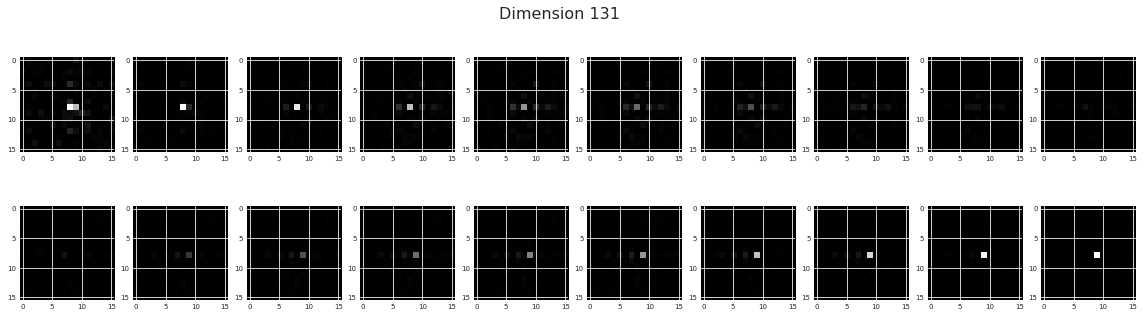

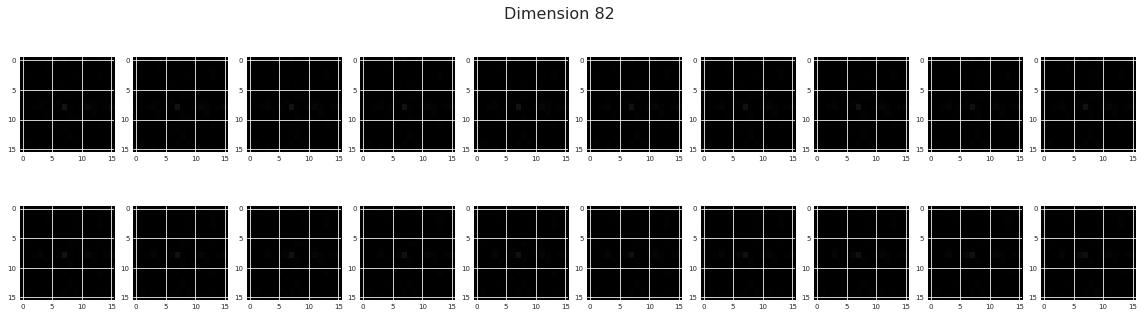

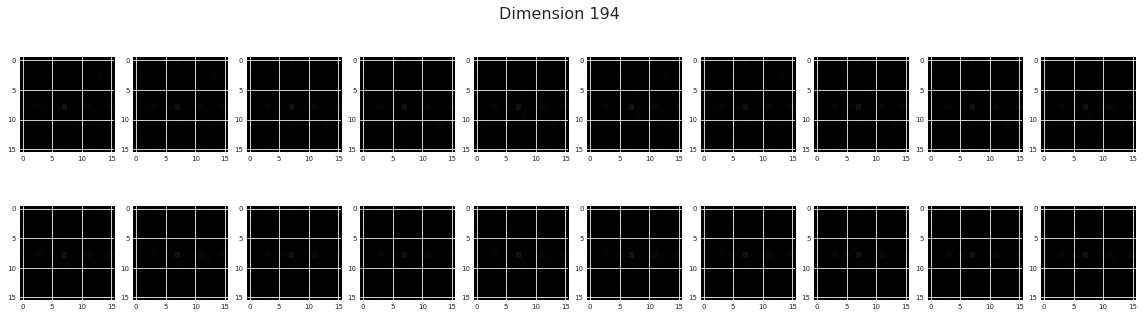

,total_loss
1310,0.532076


,total_loss
1320,0.512444


,total_loss
1330,0.51492


,total_loss
1340,0.57208


,total_loss
1350,0.546757


,total_loss
1360,0.572854


,total_loss
1370,0.593679


,total_loss
1380,0.537967


,total_loss
1390,0.548031


,total_loss
1400,0.527921


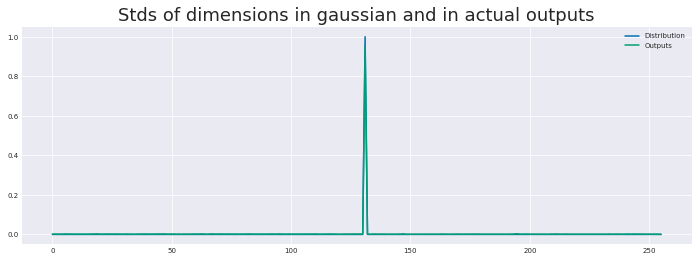

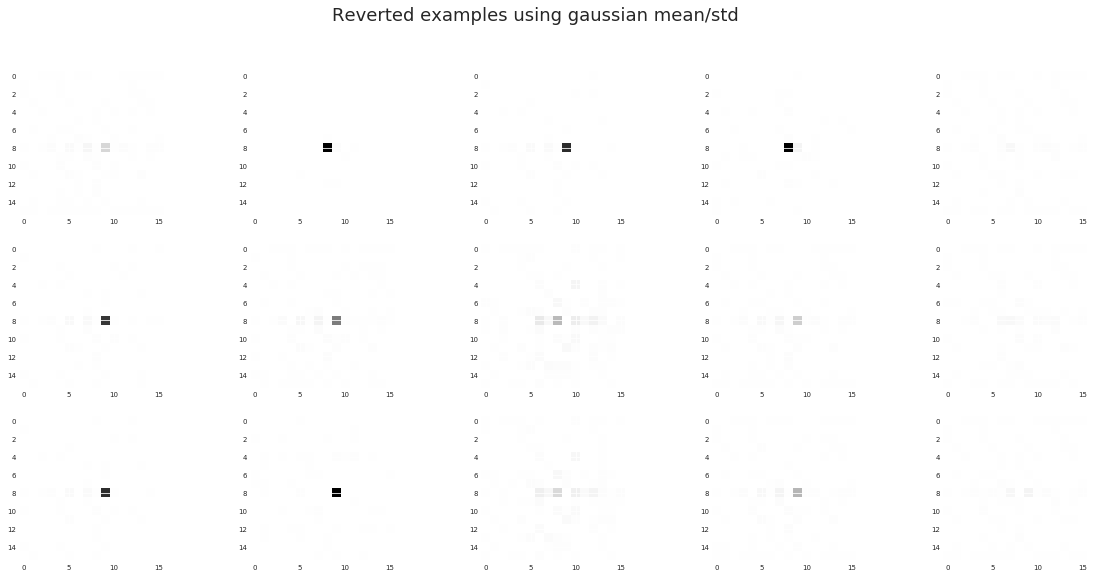

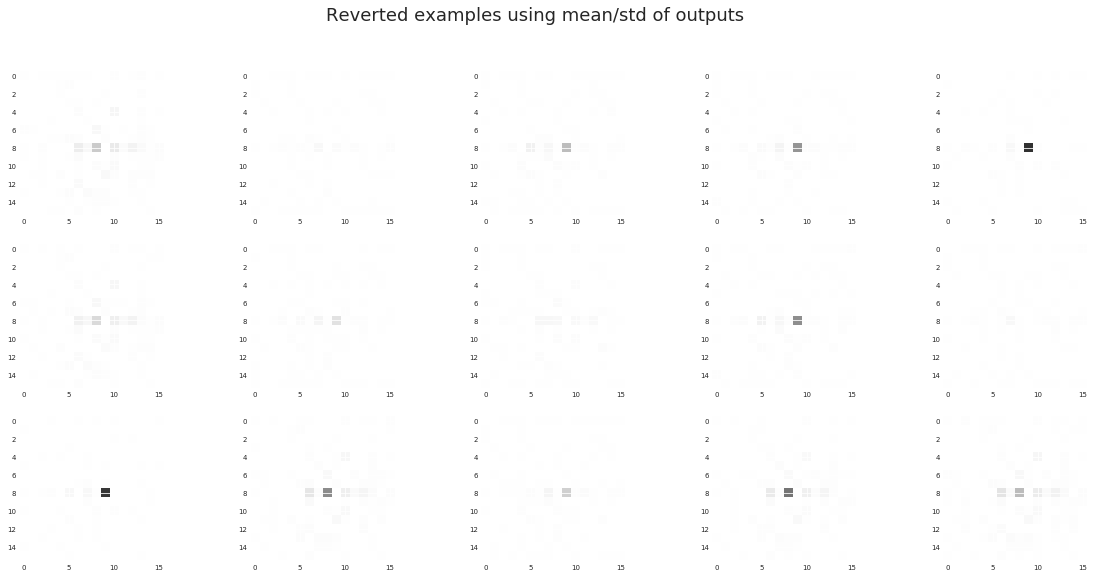

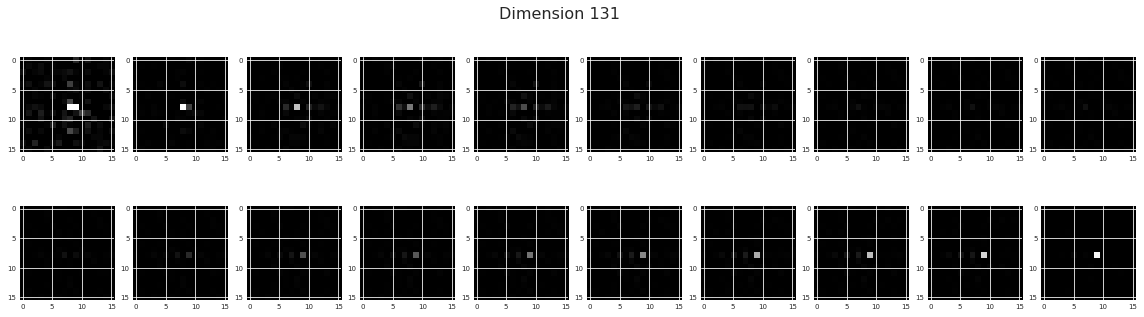

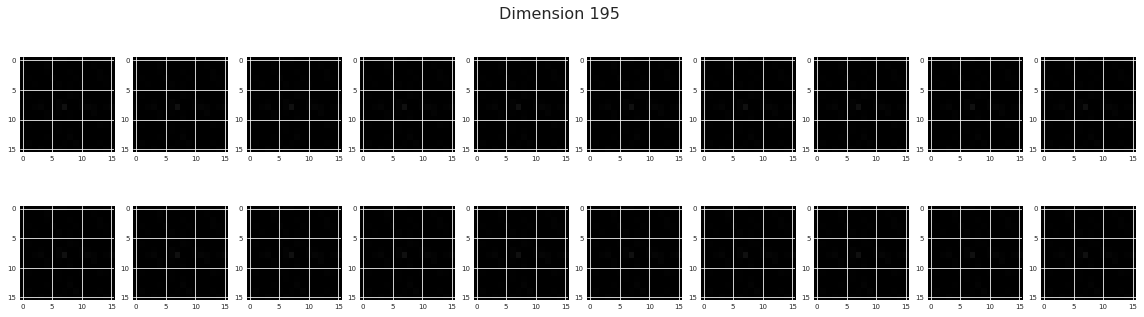

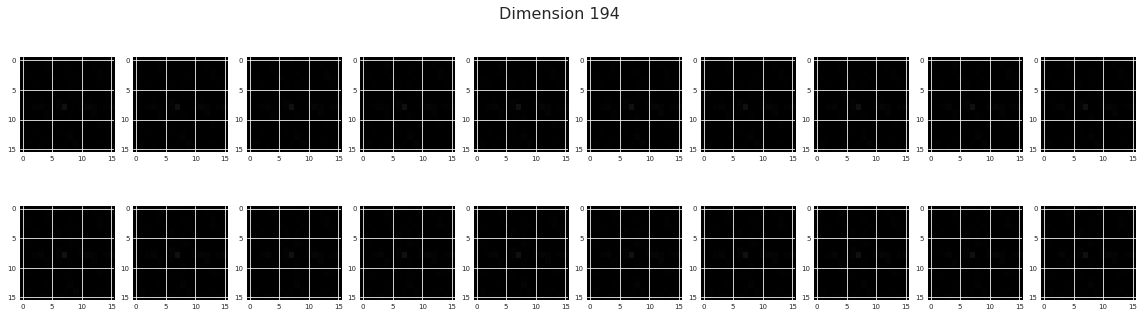

,total_loss
1410,0.529318


,total_loss
1420,0.540884


,total_loss
1430,0.545031


,total_loss
1440,0.551542


,total_loss
1450,0.569206


,total_loss
1460,0.533993


,total_loss
1470,0.56296


,total_loss
1480,0.571708


,total_loss
1490,0.560476


,total_loss
1500,0.509695


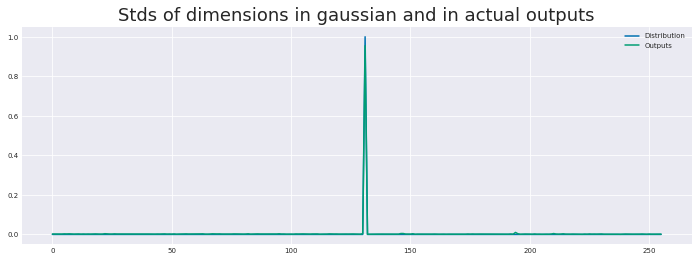

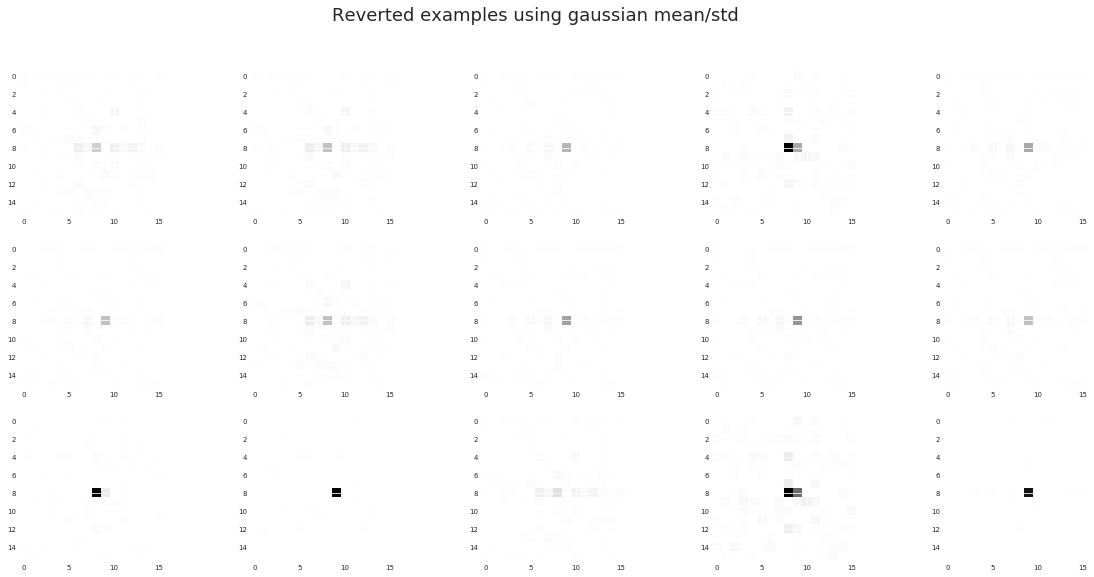

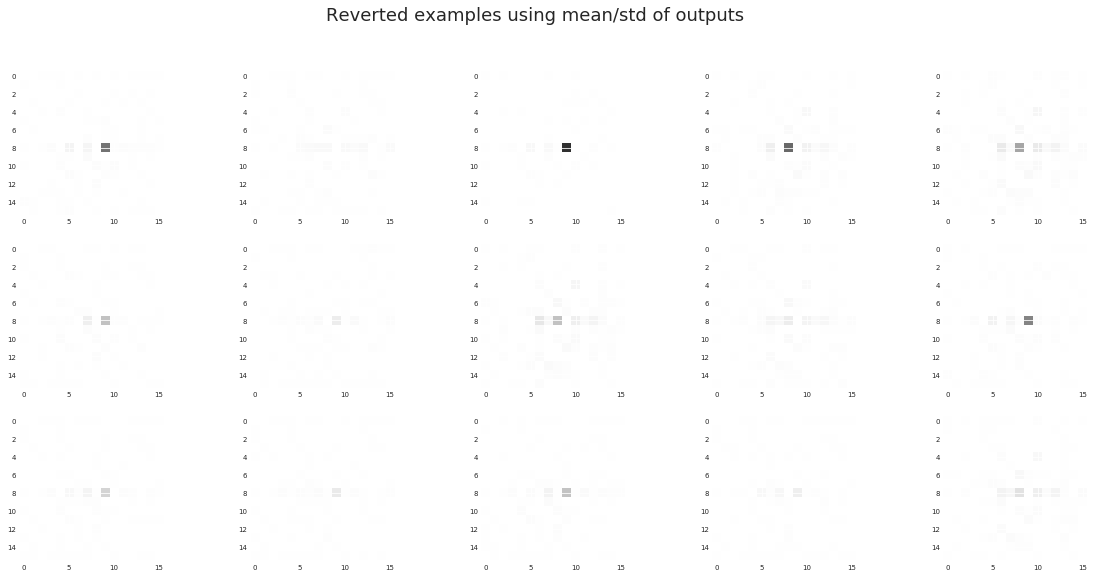

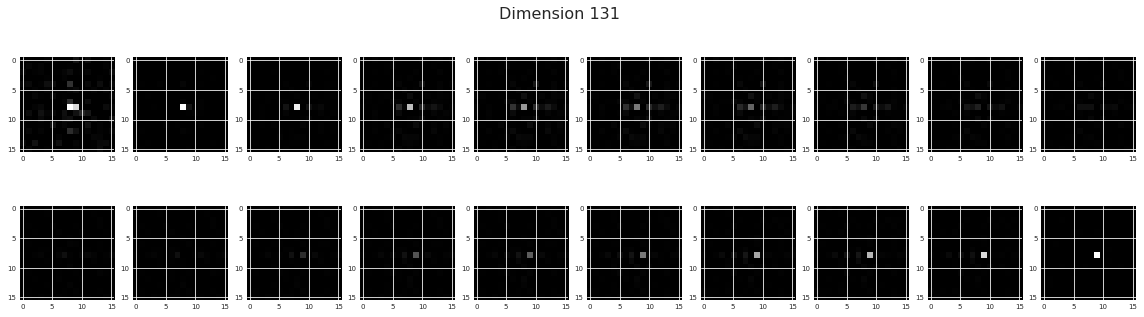

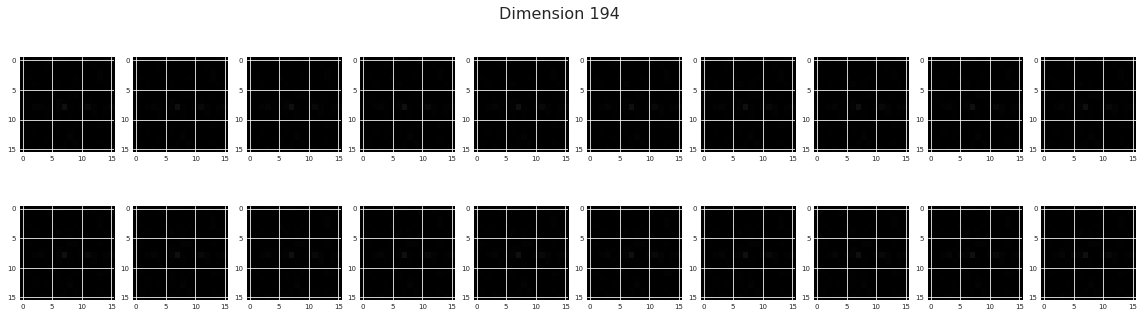

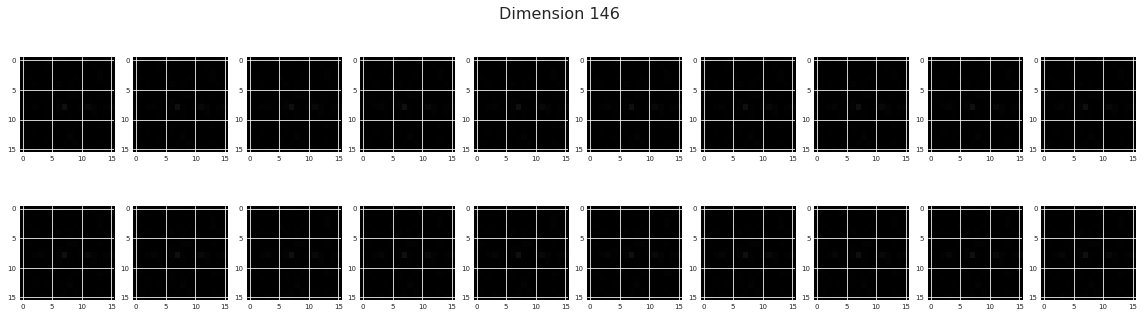

,total_loss
1510,0.554298


,total_loss
1520,0.534879


,total_loss
1530,0.545384


,total_loss
1540,0.566613


,total_loss
1550,0.547815


,total_loss
1560,0.556639


,total_loss
1570,0.563306


,total_loss
1580,0.556763


,total_loss
1590,0.565032


,total_loss
1600,0.565485


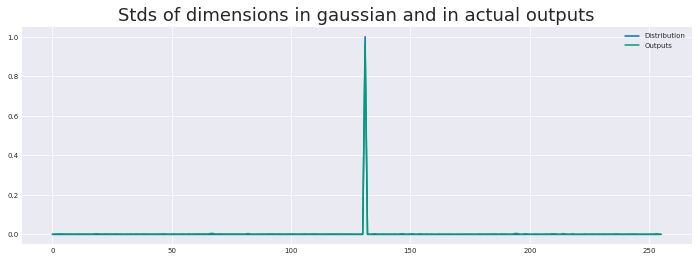

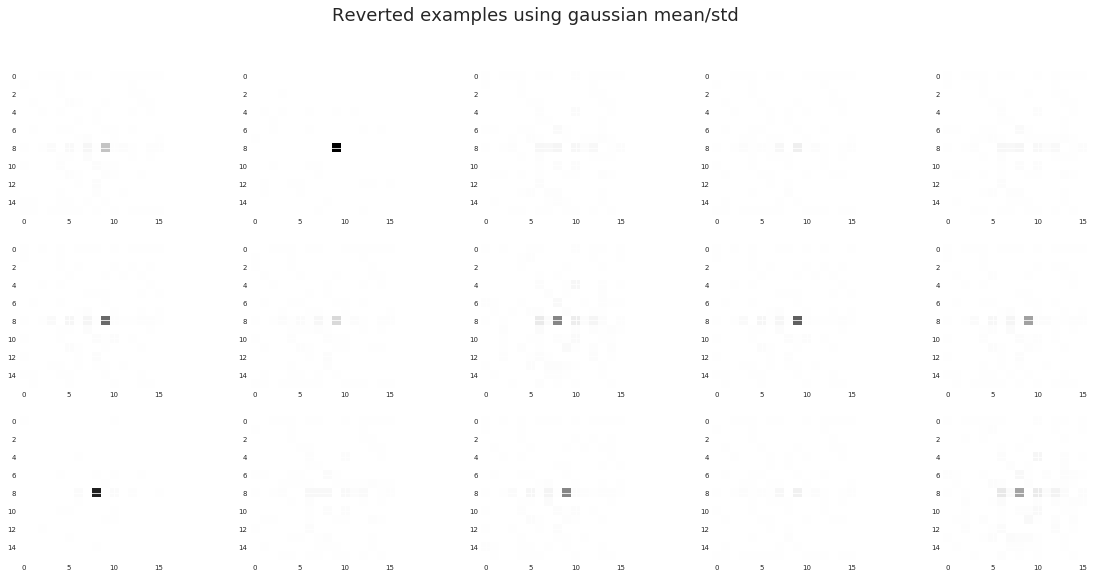

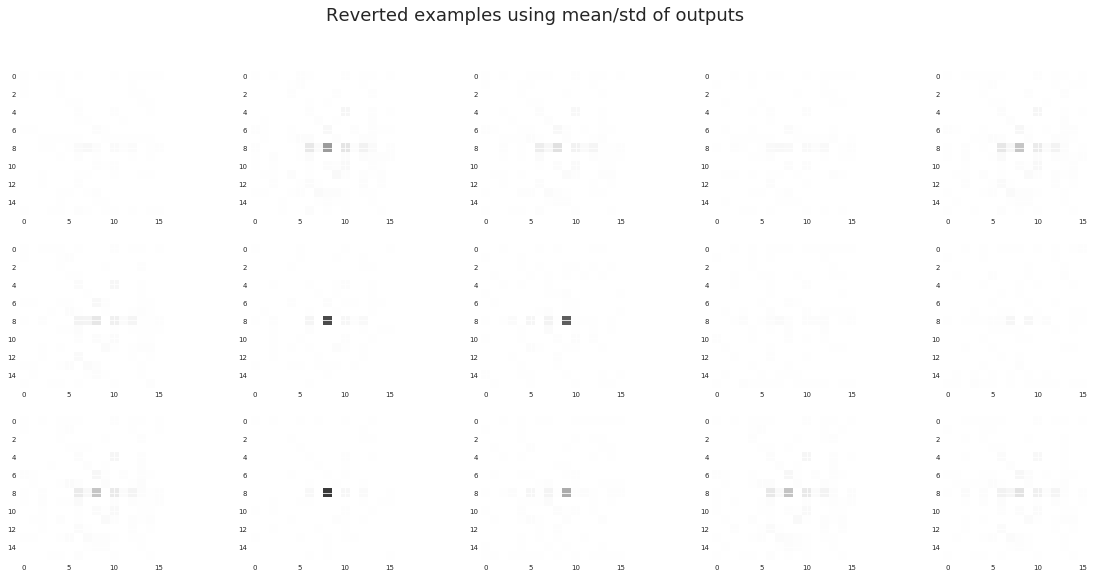

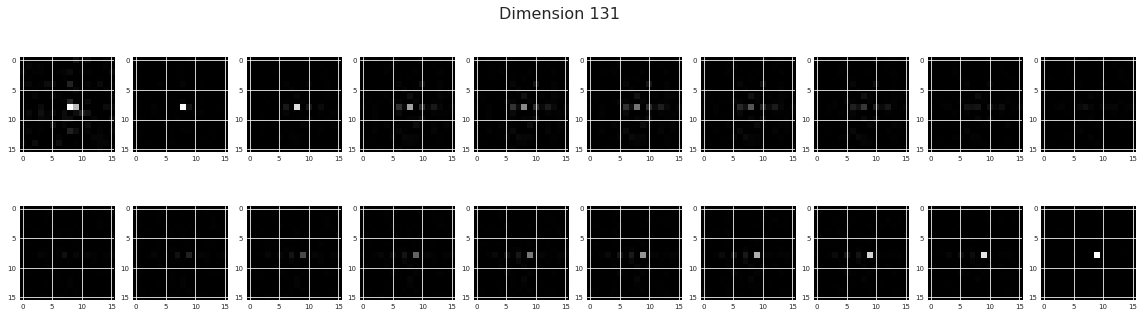

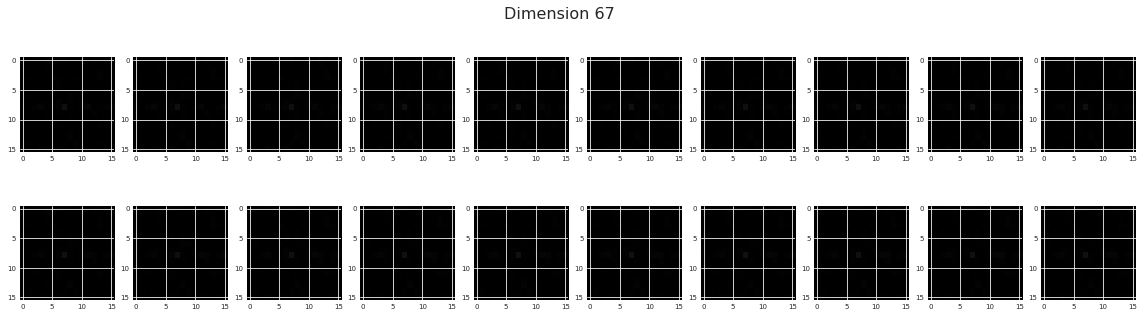

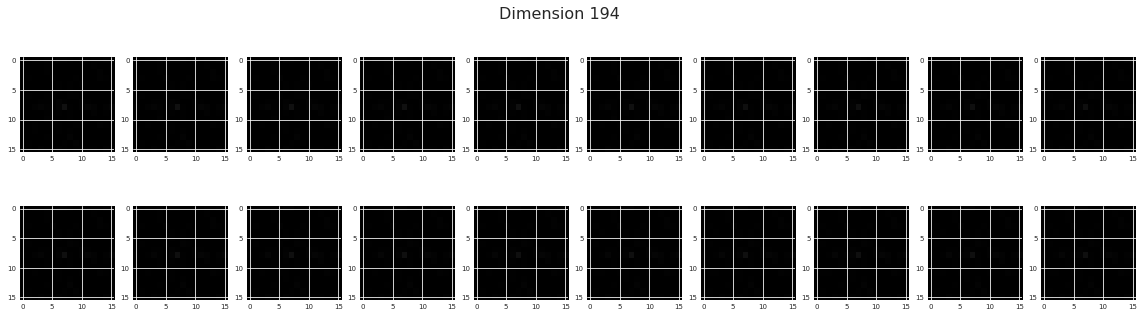

,total_loss
1610,0.53268


,total_loss
1620,0.566443


,total_loss
1630,0.527734


,total_loss
1640,0.555949


,total_loss
1650,0.577678


,total_loss
1660,0.540236


,total_loss
1670,0.509589


,total_loss
1680,0.570325


,total_loss
1690,0.525717


,total_loss
1700,0.569474


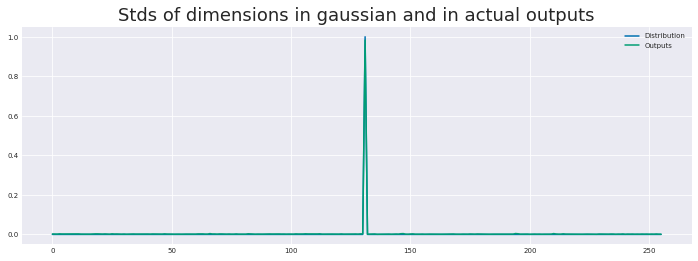

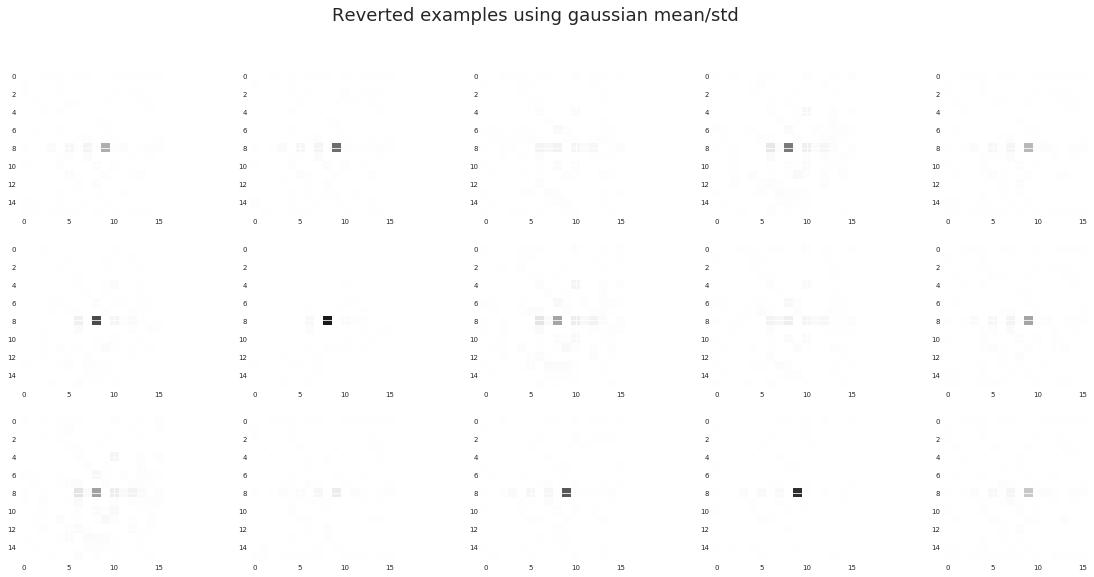

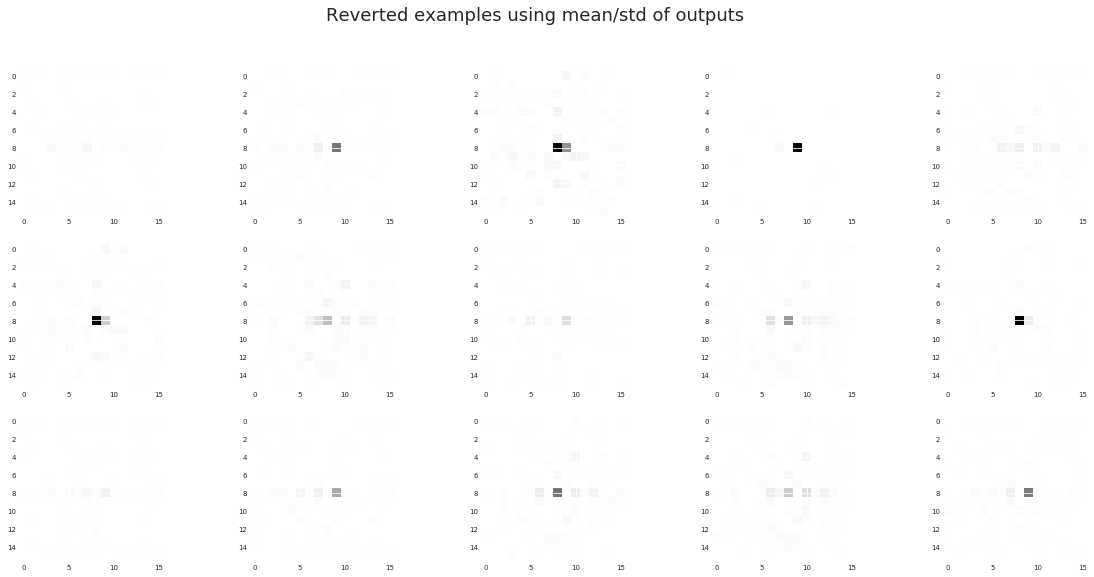

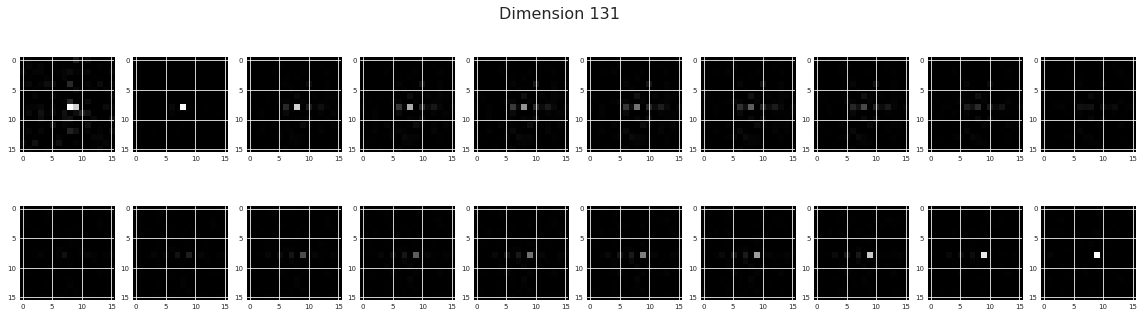

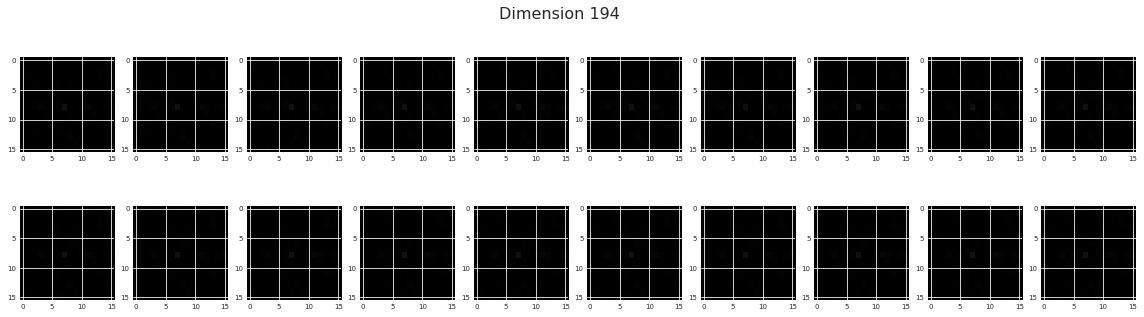

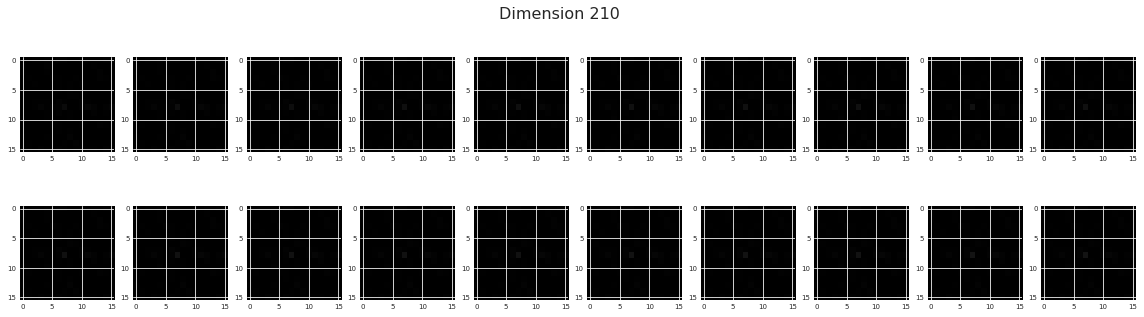

,total_loss
1710,0.519764


,total_loss
1720,0.582752


,total_loss
1730,0.5494


,total_loss
1740,0.559275


,total_loss
1750,0.614191


,total_loss
1760,0.592608


,total_loss
1770,0.572405


,total_loss
1780,0.544631


,total_loss
1790,0.545041


,total_loss
1800,0.595439


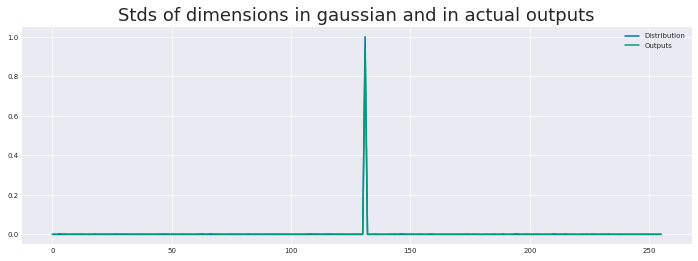

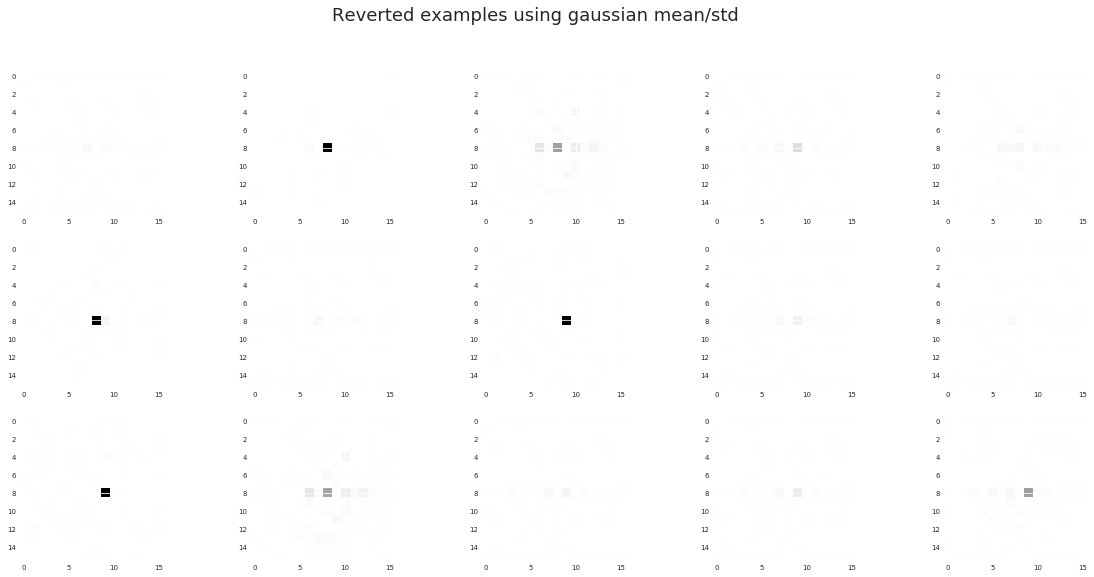

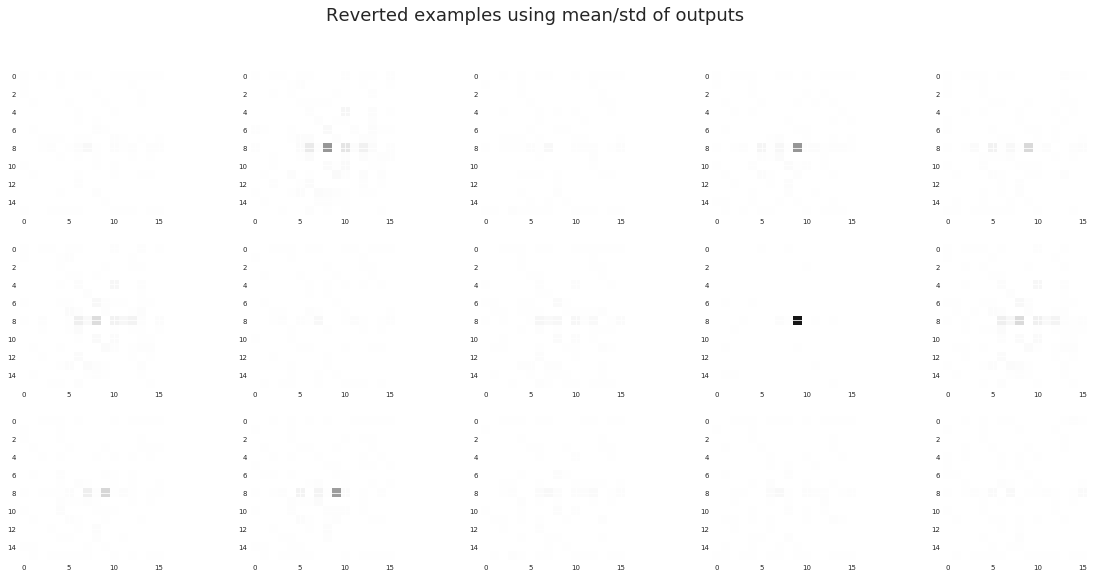

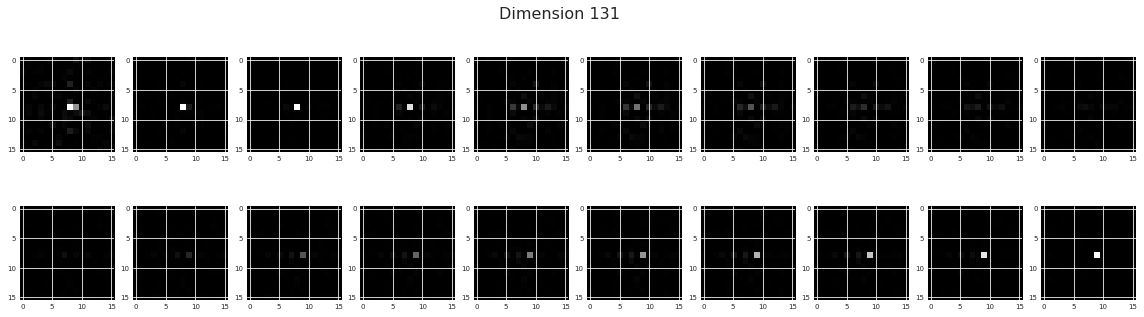

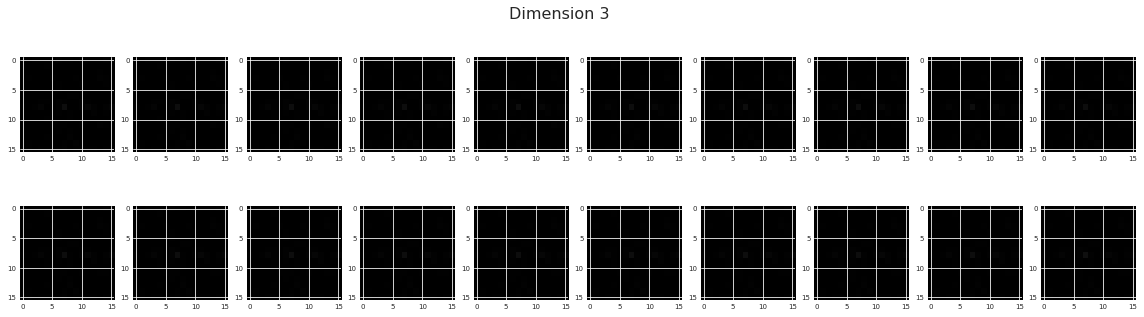

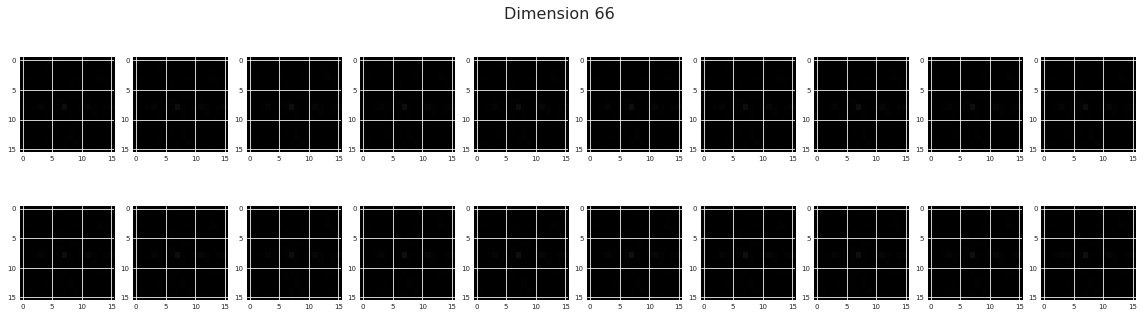

,total_loss
1810,0.519945


,total_loss
1820,0.536792


,total_loss
1830,0.556802


,total_loss
1840,0.525423


,total_loss
1850,0.562779


,total_loss
1860,0.561248


,total_loss
1870,0.588684


,total_loss
1880,0.576997


,total_loss
1890,0.536556


,total_loss
1900,0.592575


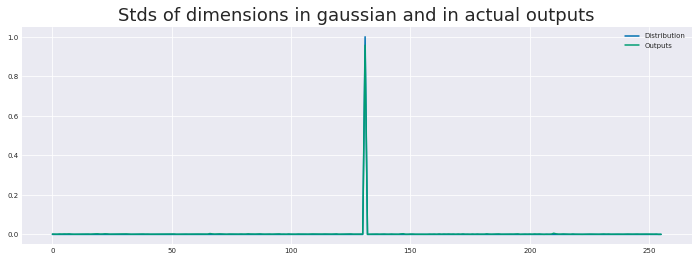

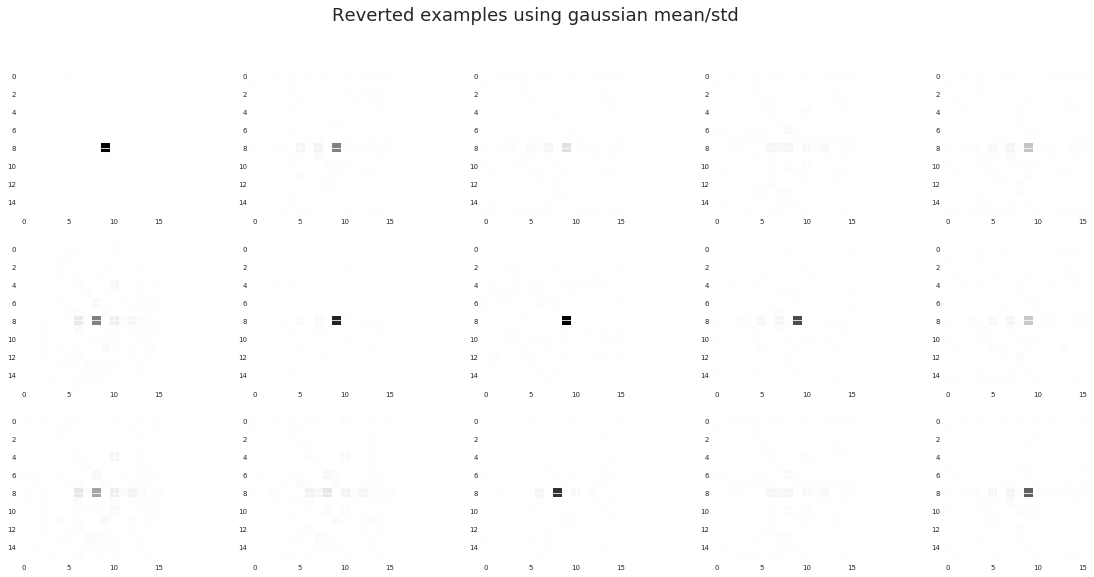

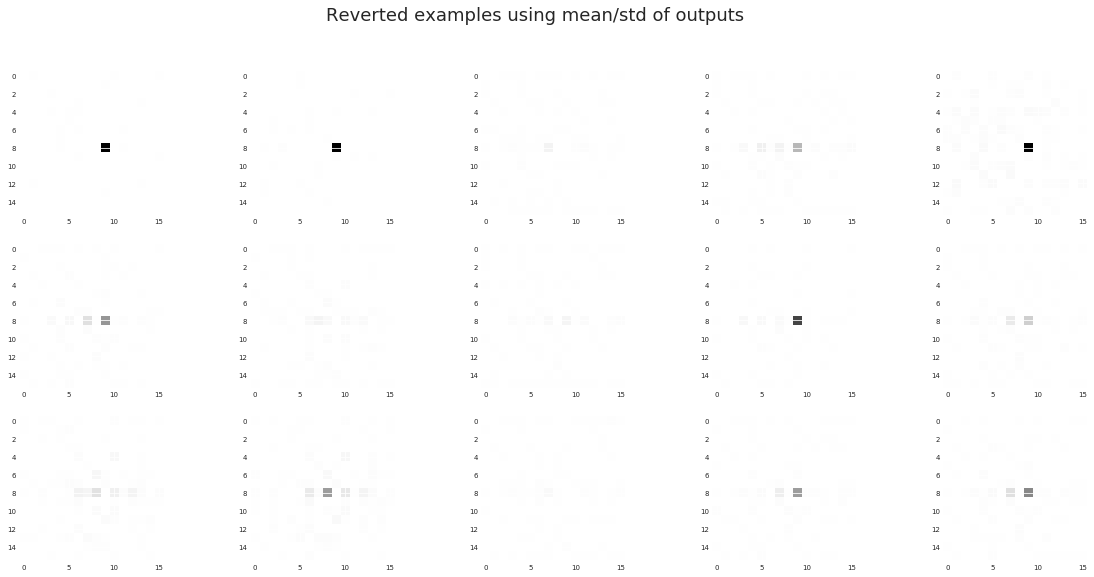

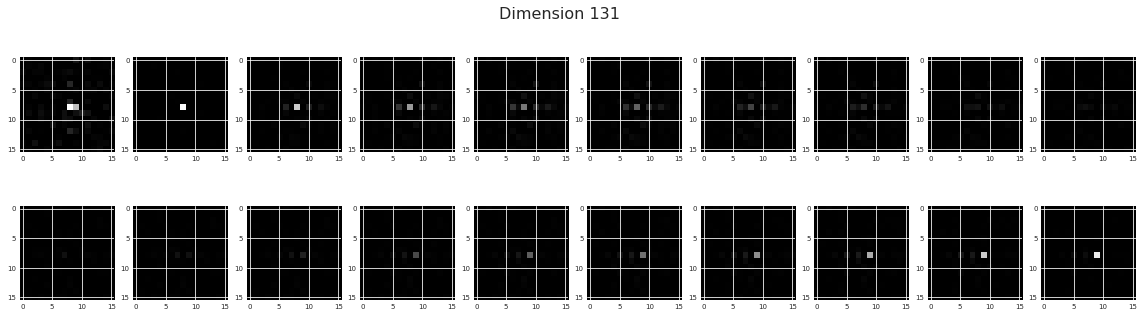

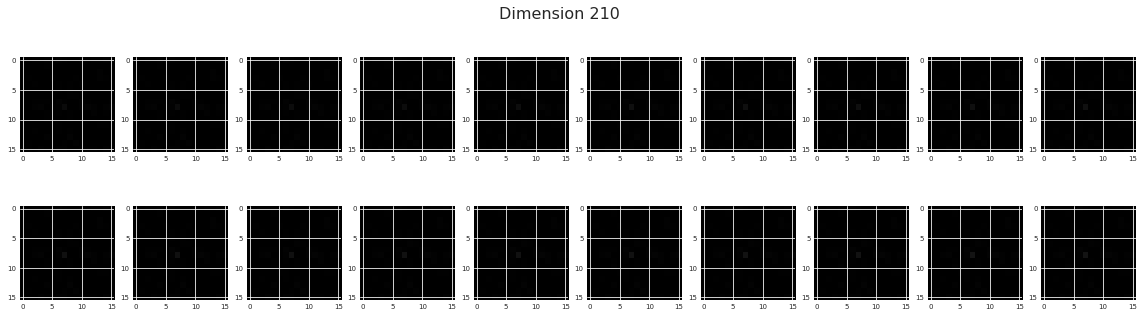

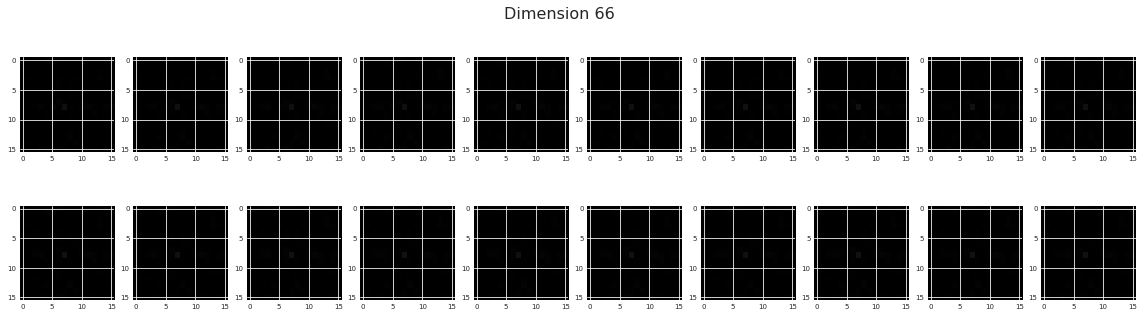

,total_loss
1910,0.575589


,total_loss
1920,0.567157


,total_loss
1930,0.599929


,total_loss
1940,0.53822


,total_loss
1950,0.551567


,total_loss
1960,0.548485


,total_loss
1970,0.508475


,total_loss
1980,0.548464


,total_loss
1990,0.555746


,total_loss
2000,0.577917


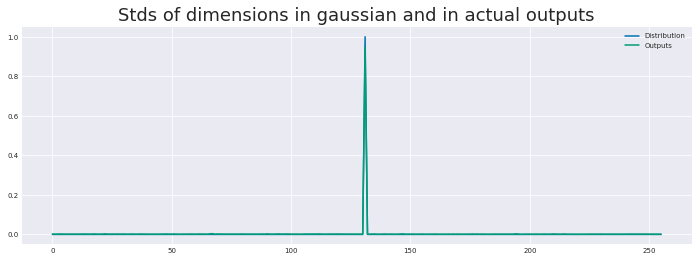

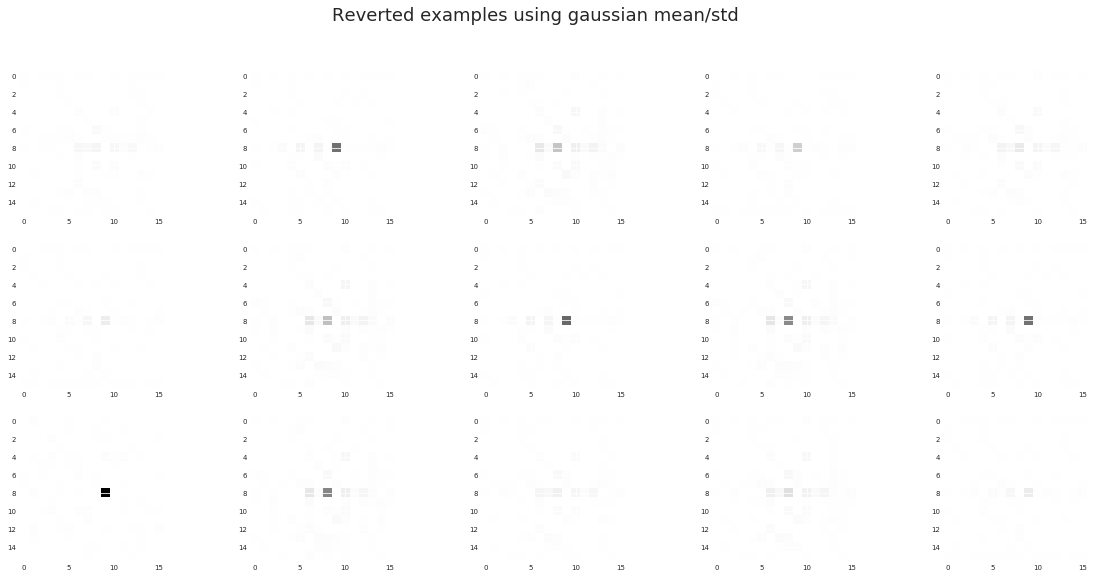

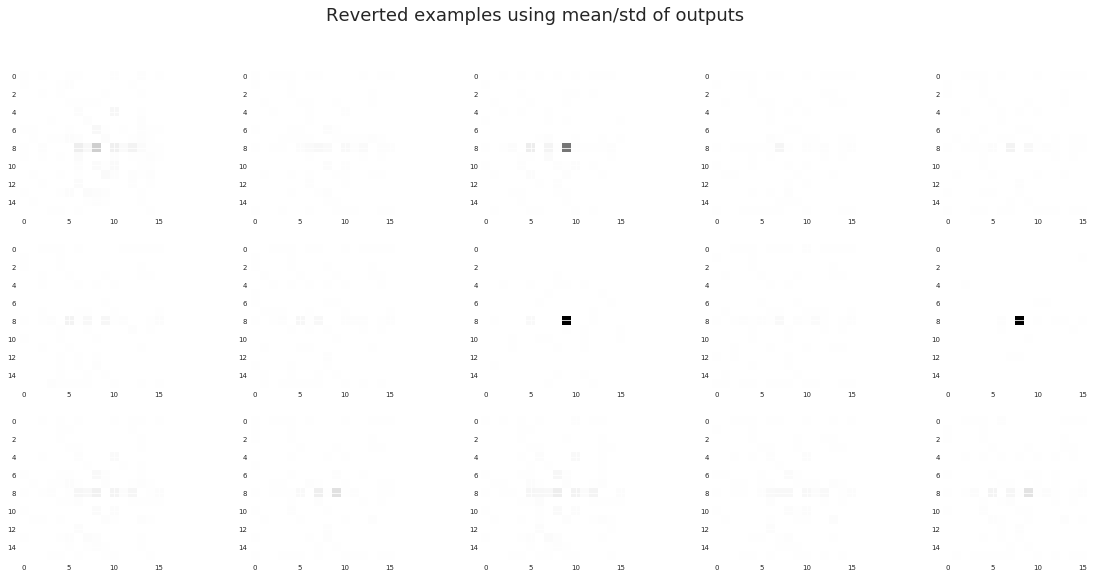

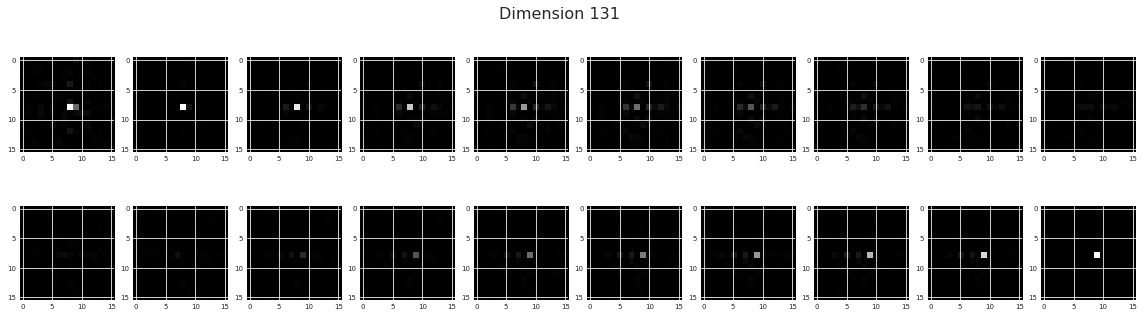

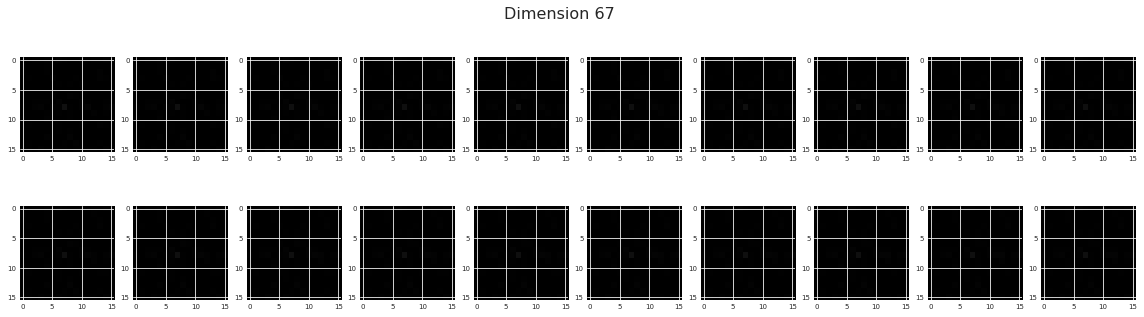

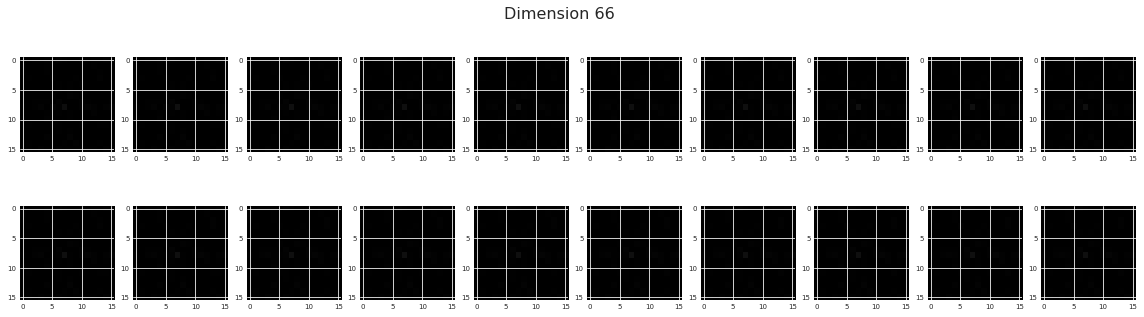

,total_loss
2010,0.568029


,total_loss
2020,0.553292


,total_loss
2030,0.52302


,total_loss
2040,0.57285


,total_loss
2050,0.570816


,total_loss
2060,0.555746


,total_loss
2070,0.568669


,total_loss
2080,0.571935


,total_loss
2090,0.538434


,total_loss
2100,0.630724


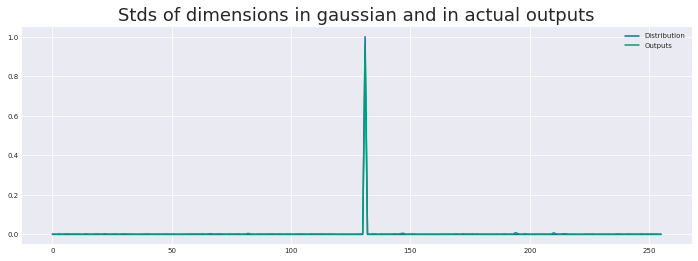

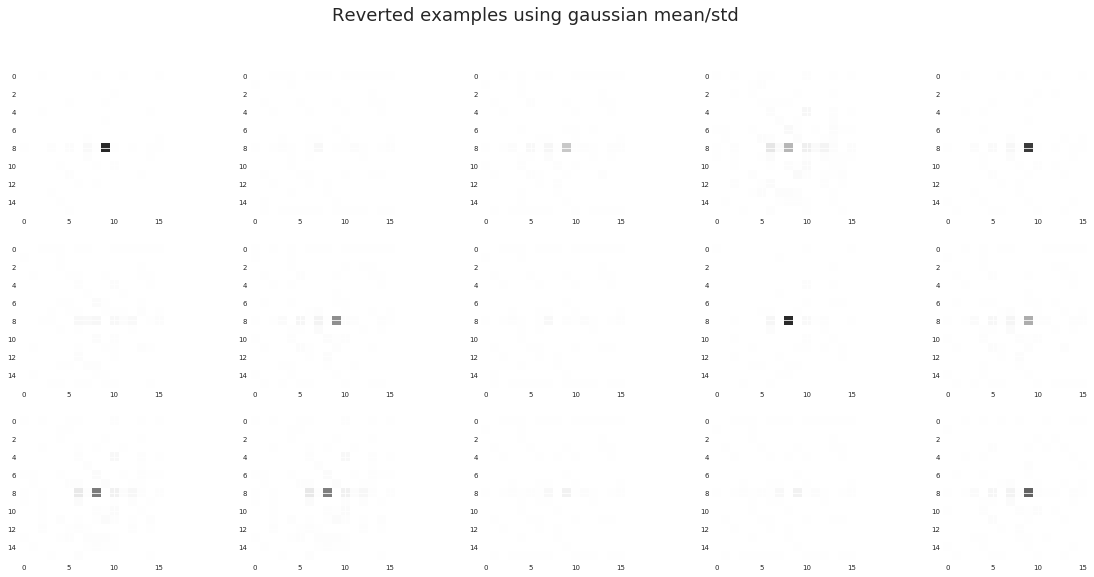

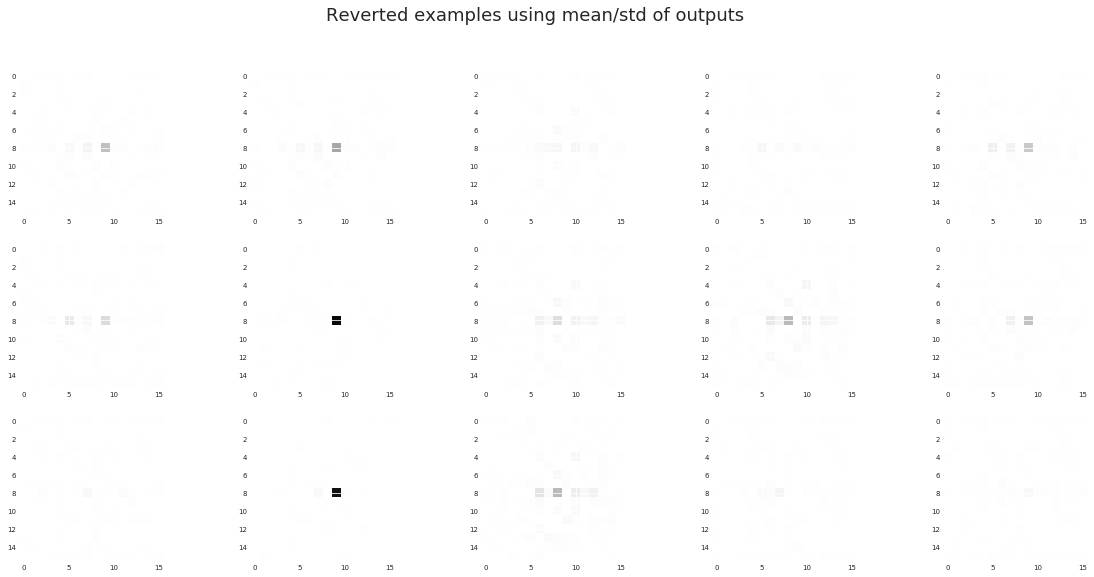

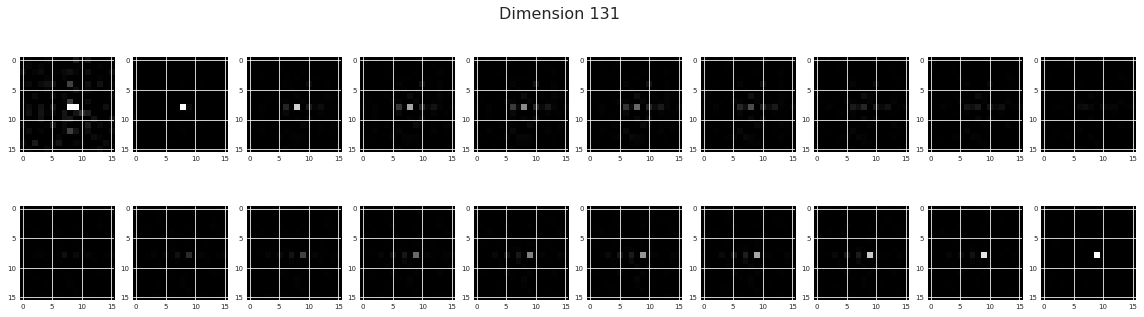

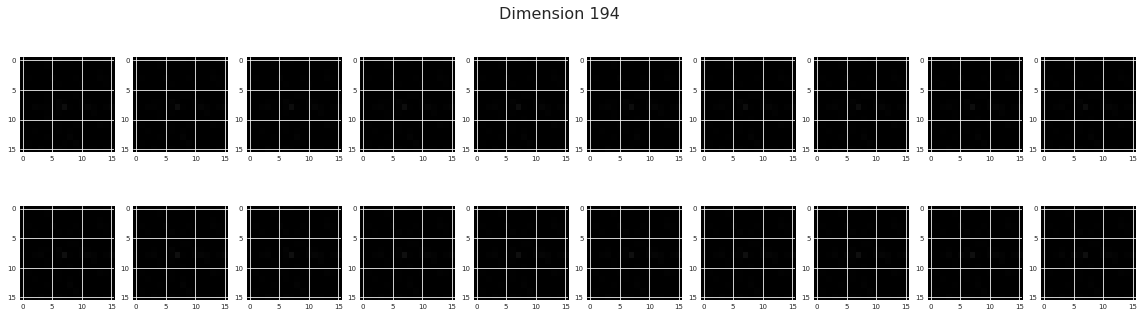

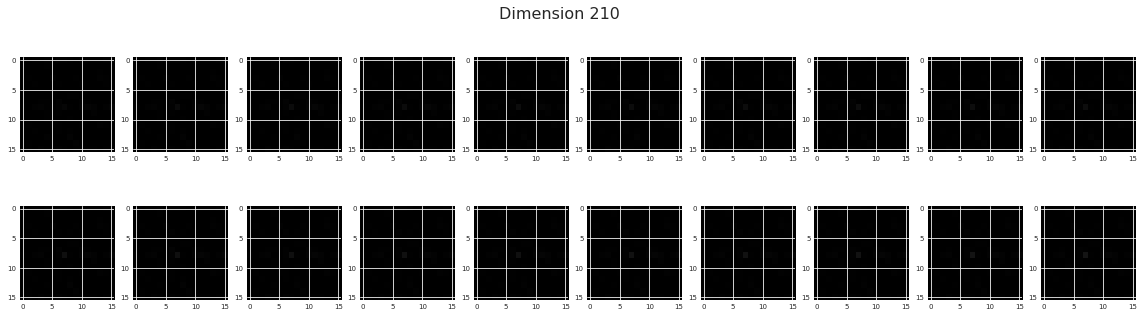

,total_loss
2110,0.53305


,total_loss
2120,0.603023


,total_loss
2130,0.54168


,total_loss
2140,0.553721


,total_loss
2150,0.579459


,total_loss
2160,0.567417


,total_loss
2170,0.546561


,total_loss
2180,0.580077


,total_loss
2190,0.531223


,total_loss
2200,0.567783


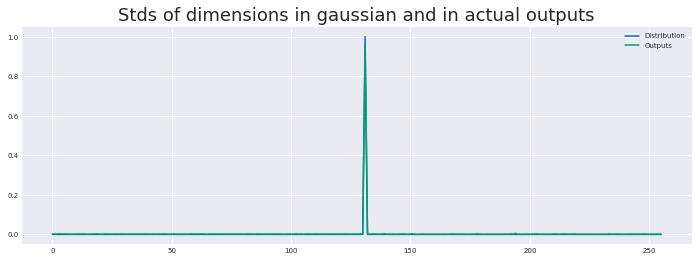

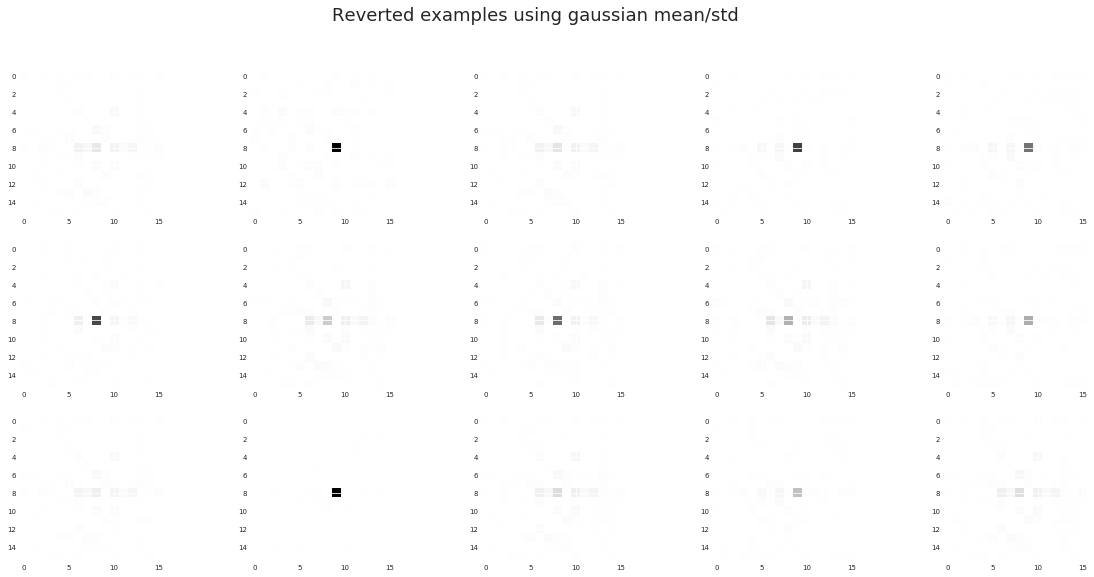

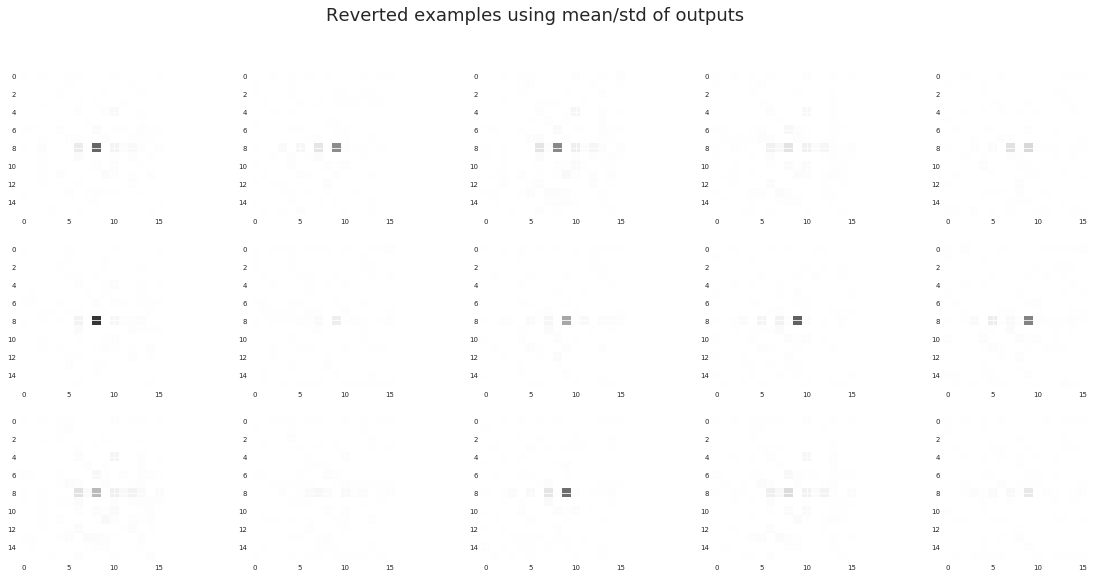

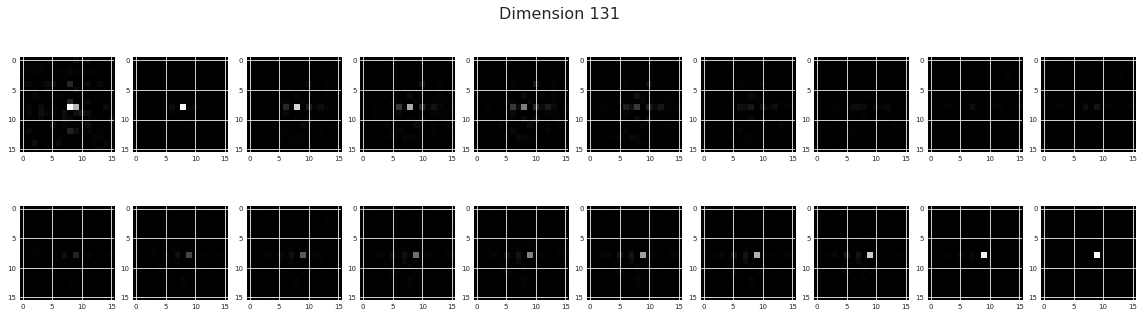

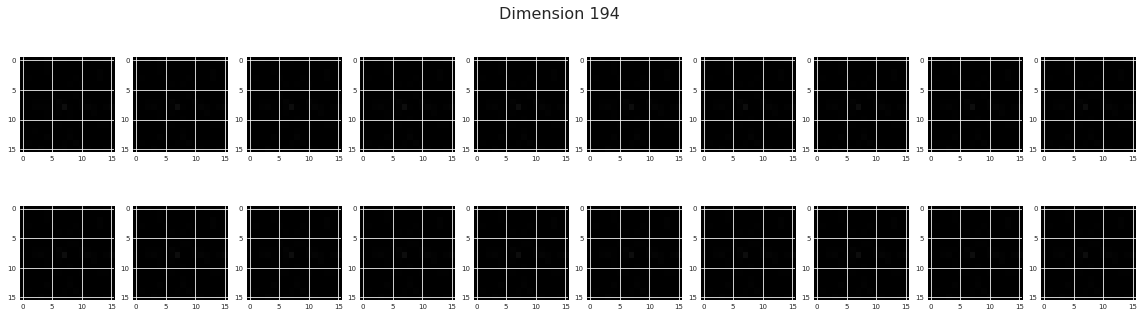

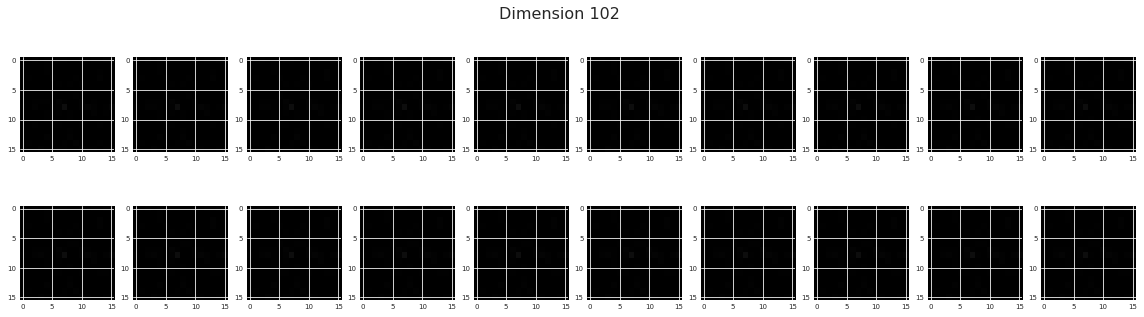

,total_loss
2210,0.513689


,total_loss
2220,0.57697


,total_loss
2230,0.546748


,total_loss
2240,0.595866


,total_loss
2250,0.547061


,total_loss
2260,0.526222


,total_loss
2270,0.562242


,total_loss
2280,0.560481


,total_loss
2290,0.604226


,total_loss
2300,0.54765


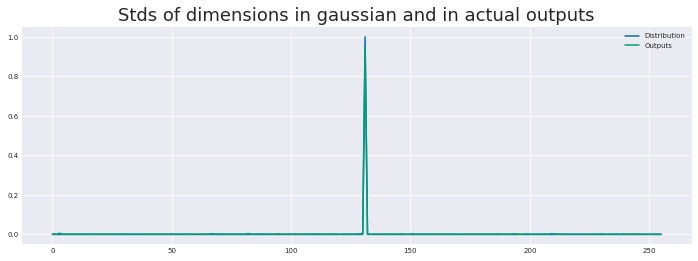

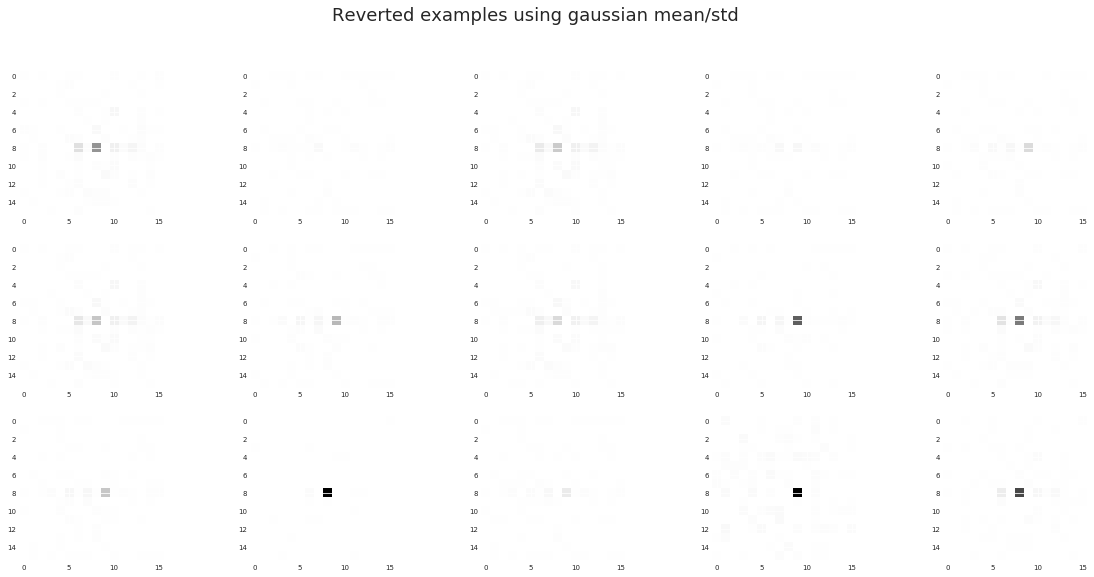

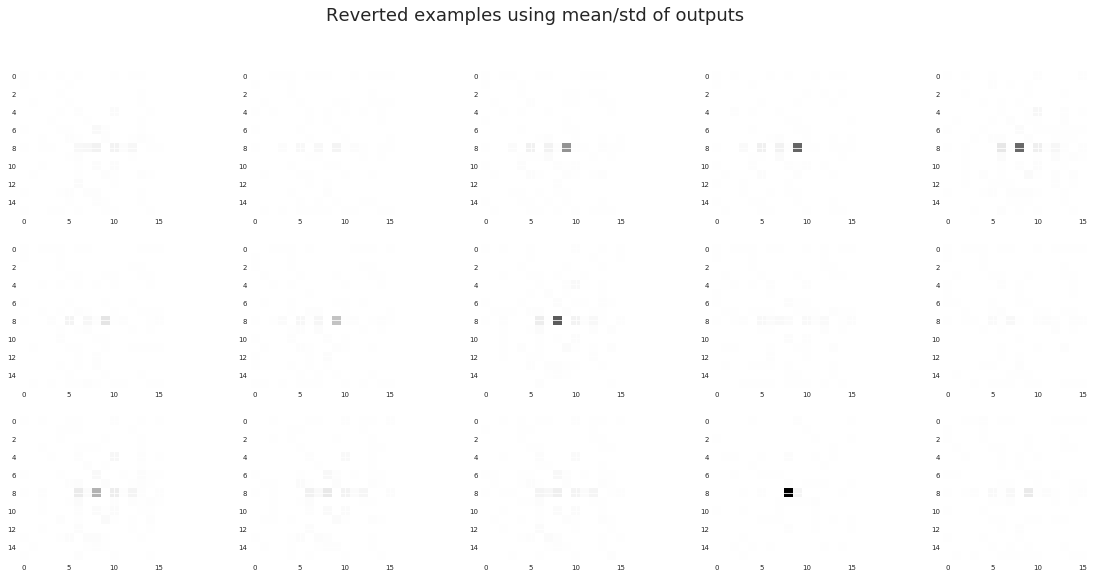

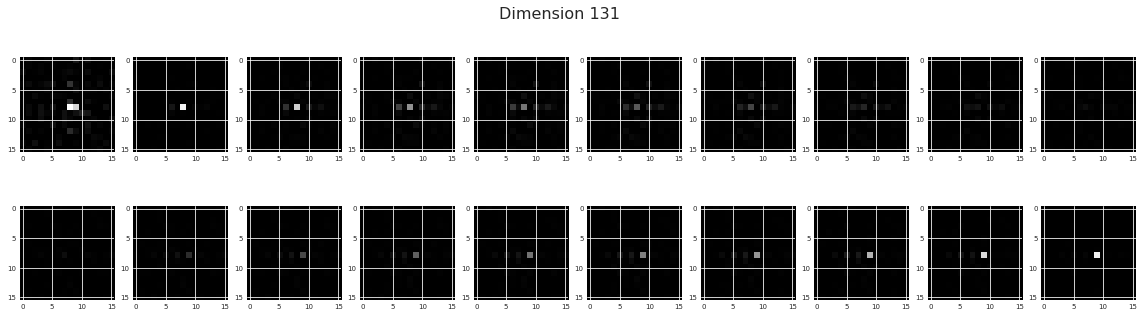

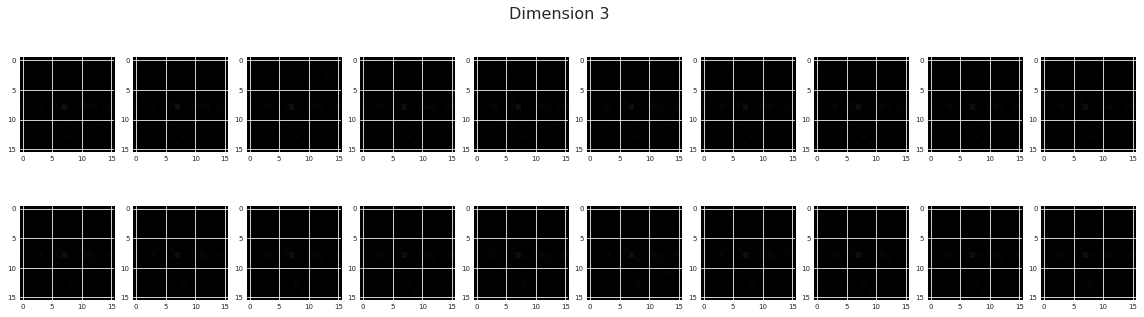

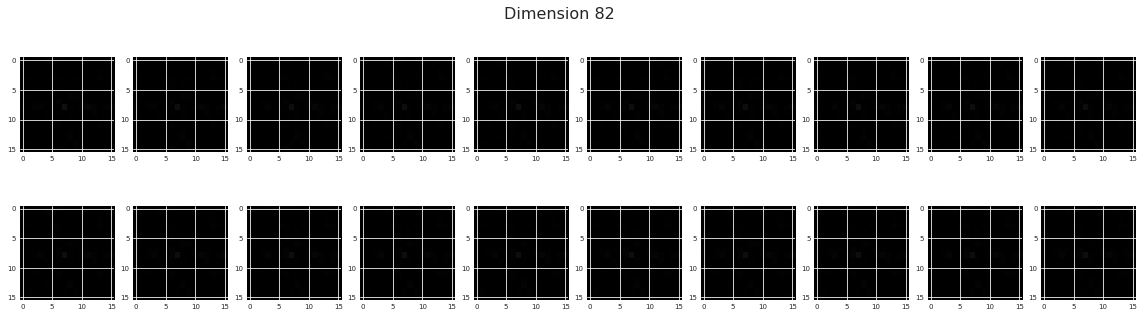

,total_loss
2310,0.583105


,total_loss
2320,0.53975


,total_loss
2330,0.573114


KeyboardInterrupt: 

In [54]:
import pandas as pd
from reversible.util import var_to_np, ensure_on_same_device
from reversible.revnet import get_inputs_from_reverted_samples


rng = RandomState(1)
epochs_dataframe = pd.DataFrame()
for i_epoch in range(100001):
    feature_model.train()
    used_stds = stds_per_dim
    for i_update in range(n_updates_per_epoch):
        if i_update % (n_critic_updates + 1) == n_critic_updates:
            # now run generator
            loss = train_one_batch(iterator, feature_model, loss_fn, means_per_dim, used_stds, optimizer)
            stds_per_dim.data.clamp_(min=0)
        else:
            loss = train_one_batch(iterator, feature_model, loss_fn_adv, means_per_dim, used_stds, optimizer_adv)
            stds_per_dim.data.clamp_(min=0) # should not be necessary...
    feature_model.eval()
    epochs_dataframe = epochs_dataframe.append({
        'total_loss': np.mean(loss),
    },
        ignore_index=True)
    if i_epoch % 10 == 0:
        display(epochs_dataframe.iloc[-1:])
    if i_epoch % 100 == 0:
        
        all_outs = feature_model(inputs)
        all_outs = var_to_np(all_outs).squeeze()
        
        for i_cluster in range(len(means_per_dim)):
            fig = plt.figure()
            plt.plot(var_to_np(used_stds[i_cluster]))
            plt.plot(np.std(all_outs[y == i_cluster], axis=0))
            plt.legend(('Distribution', 'Outputs'))
            plt.title("Stds of dimensions in gaussian and in actual outputs", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(len(means_per_dim)):
            rec_examples, _ = get_inputs_from_reverted_samples(
                 15, means_per_dim[i_cluster:i_cluster+1], used_stds[i_cluster:i_cluster+1],
                np_to_var([1,]), feature_model,
                to_4d=False)

            fig, axes = plt.subplots(3,5, figsize=(20,9))

            for i_example, ax in enumerate(axes.flatten()):
                ax.imshow(rec_examples[i_example].squeeze(), vmin=0, vmax=1, cmap=cm.Greys)
            fig.suptitle("Reverted examples using gaussian mean/std", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(len(means_per_dim)):
            mean =  np_to_var(np.mean(all_outs[y == i_cluster], axis=0, keepdims=True), dtype=np.float32)
            std = np_to_var(np.std(all_outs[y == i_cluster], axis=0, keepdims=True), dtype=np.float32)
            mean, std, inputs = ensure_on_same_device(mean,std,inputs)
            rec_examples, _ = get_inputs_from_reverted_samples(
                 15, mean, std,
                np_to_var([1,]), feature_model,
                to_4d=False)

            fig, axes = plt.subplots(3,5, figsize=(20,9))

            for i_example, ax in enumerate(axes.flatten()):
                ax.imshow(rec_examples[i_example].squeeze(), vmin=0, vmax=1, cmap=cm.Greys)
            fig.suptitle("Reverted examples using mean/std of outputs", fontsize=18)
            display(fig)
            plt.close(fig)
        
        for i_cluster in range(len(means_per_dim)):
            stds = np.std(all_outs[y == i_cluster], axis=0)
            sorted_stds = np.argsort(stds)[::-1]
            for i_large_std in sorted_stds[:3]:
                stds_cloned = used_stds.clone()
                stds_cloned = stds_cloned * 0
                stds_cloned[i_cluster,i_large_std] = float(stds[i_large_std])
                rec_examples, gauss_samples = get_inputs_from_reverted_samples(
                    200, means_per_dim[i_cluster:i_cluster+1],
                    stds_cloned[i_cluster:i_cluster+1], np_to_var([1]), feature_model, to_4d=False)
                i_sort = np.argsort(var_to_np(gauss_samples)[:, i_large_std])
                sorted_examples = rec_examples[i_sort]
                sorted_examples = sorted_examples[::200//20]
                fig = plot_sorted_examples(sorted_examples)
                fig.suptitle("Dimension {:d}".format(i_large_std), fontsize=16)
                display(fig)
                plt.close(fig)

In [24]:
all_outs = feature_model(inputs)
all_outs = var_to_np(all_outs)

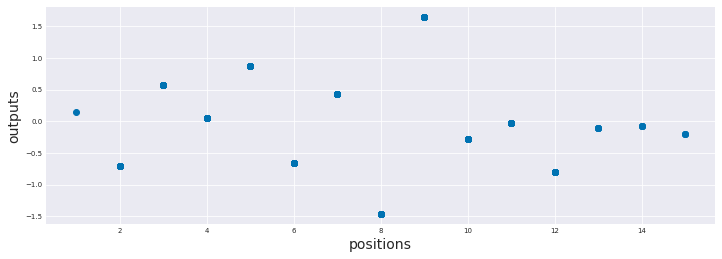

In [27]:
vals = all_outs[:,131]
plt.plot(positions, vals, ls='', marker='o')
plt.xlabel('positions', fontsize=14)
plt.ylabel('outputs', fontsize=14)

In [36]:
wanted = [np.flatnonzero(x[:,0,8,i_pos])[0] for i_pos in np.unique(positions)]

In [42]:
this_in = inputs.index_select(dim=0, index=np_to_var(wanted, dtype=np.int64).cuda())

In [45]:
this_outs = var_to_np(feature_model(this_in))

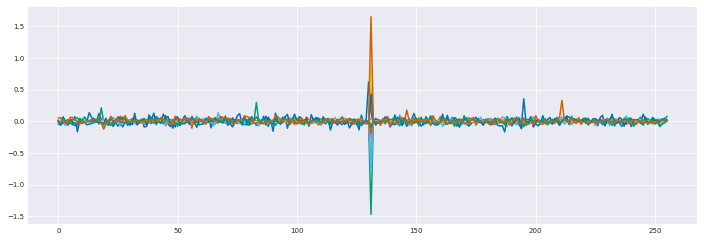

In [48]:
plt.plot(this_outs.T);

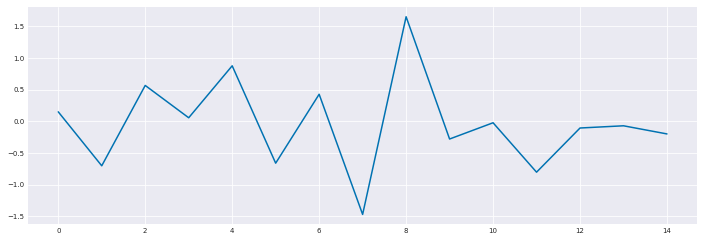

In [49]:
plt.plot(this_outs[:,131])

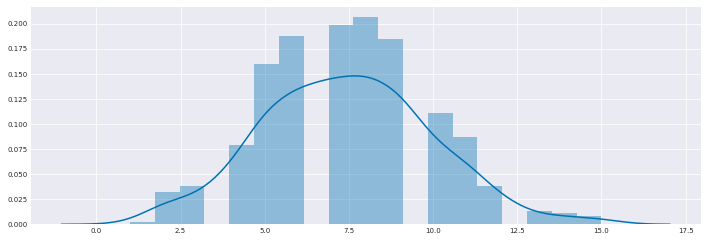

In [31]:
seaborn.distplot(positions)

In [29]:
all_outs[:,131]

array([-1.47033215,  1.64844644,  0.42541194,  0.42541194,  0.42541194,
       -0.66206443, -0.66206443, -0.28067812,  1.64844644,  0.42541194,
       -1.47033215,  0.42541194, -0.66206443, -1.47033215,  1.64844644,
       -0.66206443,  1.64844644, -0.28067812, -0.70315814,  0.87444562,
        0.87444562,  1.64844644,  1.64844644,  0.87444562,  0.05459582,
        1.64844644, -1.47033215, -1.47033215,  0.87444562,  1.64844644,
       -1.47033215, -0.28067812, -0.80390859,  0.42541194,  0.42541194,
       -1.47033215,  0.42541194,  0.42541194, -0.66206443, -0.02432314,
        1.64844644,  0.87444562,  0.42541194, -0.28067812,  0.42541194,
       -0.20052752,  0.87444562,  0.42541194,  0.42541194,  0.87444562,
        1.64844644, -0.66206443, -1.47033215, -0.28067812,  0.05459582,
        1.64844644, -1.47033215, -1.47033215, -1.47033215,  1.64844644,
        0.87444562, -0.28067812, -1.47033215,  1.64844644, -0.28067812,
        1.64844644,  0.87444562, -1.47033215, -0.66206443, -1.47